In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm
import collections
%matplotlib inline

In [2]:
import catboost

In [3]:
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
import operator

In [6]:
import mne

In [7]:
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]

In [8]:
raw_fnames = ['data/S001R06.edf',
              'data/S001R10.edf',
              'data/S001R14.edf']

In [9]:
def get_class_eeg(raw_name_path, name):
    raw0 = read_raw_edf(raw_name_path, preload=True)
    eegbci.standardize(raw0)
    montage = make_standard_montage('standard_1005')
    raw0.set_montage(montage)
    raw0.rename_channels(lambda x: x.strip('.'))
    raw0.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
    
    eeg1 = raw0.get_data()
    
    with open(f'data/S001/{name}_onsets_start.txt', 'r') as fin:
        start = list(map(lambda x: float(x.strip('\n')), fin.readlines()))
    
    with open(f'data/S001/{name}_onsets_end.txt', 'r') as fin:
        end = list(map(lambda x: float(x.strip('\n')), fin.readlines()))

    with open(f'data/S001/{name}_labels.txt', 'r') as fin:
        labels = list(map(lambda x: int(x.strip('\n')), fin.readlines()))
        
    one_colums_sec = end[-1] / eeg1.shape[1]
    
    eeg1_0 = np.zeros((64, 20000))
    eeg1_1 = np.zeros((64, 20000))
    eeg1_2 = np.zeros((64, 20000))

    for s,e,l in zip(start, end, labels):
        columns_start = round(s / one_colums_sec)
        columns_end = round(e / one_colums_sec)
        
        if columns_start == 1:
            columns_start -= 1

        if l == 0:
            eeg1_0[:, columns_start:columns_end] = eeg1[:, columns_start:columns_end]
        elif l == 1:
            eeg1_1[:, columns_start:columns_end] = eeg1[:, columns_start:columns_end]
        elif l == 2:
            eeg1_2[:, columns_start:columns_end] = eeg1[:, columns_start:columns_end]

            
    eeg1_0  = pd.DataFrame(eeg1_0)
    eeg1_1 = pd.DataFrame(eeg1_1)
    eeg1_2 = pd.DataFrame(eeg1_2)

    eeg1_0 = eeg1_0.loc[:, (eeg1_0 != 0).any(axis=0)]
    eeg1_1 = eeg1_1.loc[:, (eeg1_1 != 0).any(axis=0)]
    eeg1_2 = eeg1_2.loc[:, (eeg1_2 != 0).any(axis=0)]
    
    return eeg1_0, eeg1_1, eeg1_2

In [10]:
eeg1_0, eeg1_1, eeg1_2 = get_class_eeg(raw_fnames[0], 'S001R06')
eeg2_0, eeg2_1, eeg2_2 = get_class_eeg(raw_fnames[1], 'S001R10')
eeg3_0, eeg3_1, eeg3_2 = get_class_eeg(raw_fnames[2], 'S001R14')

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1999

In [11]:
print(eeg1_0.shape, eeg1_1.shape, eeg1_2.shape)
print(eeg2_0.shape, eeg2_1.shape, eeg2_2.shape)
print(eeg3_0.shape, eeg3_1.shape, eeg3_2.shape)

(64, 10120) (64, 4612) (64, 5268)
(64, 10120) (64, 4609) (64, 5271)
(64, 10120) (64, 4611) (64, 5269)


In [12]:
print(eeg1_0.shape[1] + eeg1_1.shape[1] + eeg1_2.shape[1],
eeg2_0.shape[1] + eeg2_1.shape[1] + eeg2_2.shape[1],
eeg2_0.shape[1] + eeg2_1.shape[1] + eeg2_2.shape[1])

20000 20000 20000


In [13]:
eeg_class0 = pd.concat([eeg1_0, eeg2_0, eeg3_0], axis=1)
eeg_class1 = pd.concat([eeg1_1, eeg2_1, eeg3_1], axis=1)
eeg_class2 = pd.concat([eeg1_2, eeg2_2, eeg3_2], axis=1)

In [14]:
class_0 = eeg_class0.shape[1]
class_1 = eeg_class1.shape[1]
class_2 = eeg_class2.shape[1]

In [15]:
EEG = pd.concat([eeg_class0, eeg_class1, eeg_class2], axis=1)
EEG.shape

(64, 60000)

In [16]:
EEG.columns = list(map(lambda x: str(x), np.arange(0, 60000)))

In [17]:
matrix = EEG
size = matrix.shape
class_0 = eeg_class0.shape[1]
class_1 = eeg_class1.shape[1]
class_2 = eeg_class2.shape[1]


CHANALS = 64
N_COMPONENTS_PCA = 60
FREQ = 160

TIME_SEC = 373.5

TIME_SIZE_SEC = 2
STEP_TIME_SEC = 1

SAMPLE_SIZE = TIME_SIZE_SEC * FREQ
STEP_TIME = STEP_TIME_SEC * FREQ

LINSPACE = 0, TIME_SEC, FREQ*TIME_SEC

In [18]:
matrix.shape

(64, 60000)

In [19]:
from sklearn.decomposition import FastICA

FastICA = FastICA(n_components=CHANALS).fit(matrix.T)
ICA = FastICA.transform(matrix.T)


In [20]:
matrix = ICA.T

In [21]:
matrix

array([[-3.87294299e-08,  7.29518403e-03,  1.06056157e-02, ...,
        -4.21551536e-05, -2.13590866e-05, -3.87294299e-08],
       [ 7.13190825e-08,  3.01077038e-03,  2.43131733e-03, ...,
        -2.29552321e-05, -1.15762811e-05,  7.13190825e-08],
       [-1.13797424e-07,  1.46870466e-03,  2.39464130e-03, ...,
        -1.37086993e-06, -5.96439159e-07, -1.13797424e-07],
       ...,
       [ 4.61573981e-08, -8.74366205e-04, -1.26800697e-03, ...,
        -1.42080271e-06, -6.42162673e-07,  4.61573981e-08],
       [-1.43120192e-07, -6.85884122e-03, -8.46247075e-03, ...,
         3.33258106e-05,  1.88931968e-05, -1.43120192e-07],
       [ 1.26143730e-06,  7.81061890e-04,  1.46922964e-04, ...,
        -4.07536449e-05, -1.90312230e-05,  1.26143730e-06]])

In [22]:
matrix_class1 = matrix[:, 0:class_0]
matrix_calss2 = matrix[:, class_0:class_0+class_1]
matrix_calss3 = matrix[:, class_0+class_1:class_0+class_1+class_2]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1, sample_size=SAMPLE_SIZE, step=STEP_TIME)
sample_calss2 = get_sample(matrix_calss2, sample_size=SAMPLE_SIZE, step=STEP_TIME)
sample_calss3 = get_sample(matrix_calss3, sample_size=SAMPLE_SIZE, step=STEP_TIME)


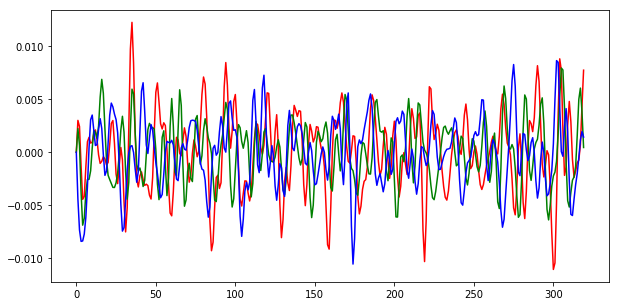

In [23]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[0][1], c='r')
plt.plot(sample_calss1[0][10], c='g')
plt.plot(sample_calss1[0][30], c='b')
plt.show()

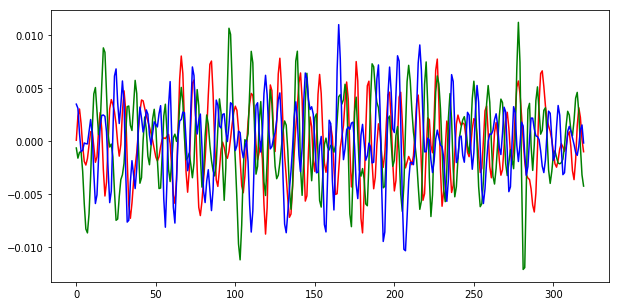

In [24]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][2], c='r')
plt.plot(sample_calss1[10][3], c='g')
plt.plot(sample_calss1[10][4], c='b')
plt.show()

In [25]:
i_ = 0
for i in range(len(sample_calss1)):
    for j in range(sample_calss1[0].shape[0]):
        #print(sample_calss1[i][j].shape[0])
        if sample_calss1[i][j].shape[0] != SAMPLE_SIZE:
            if i_ == 0:
                i_ = i

In [26]:
sample_calss1 = sample_calss1[:i_]
sample_calss2 = sample_calss2[:i_]
sample_calss3 = sample_calss3[:i_]

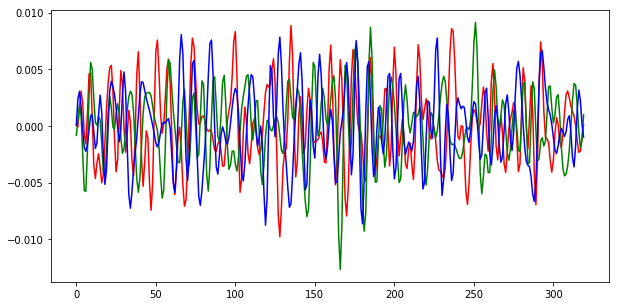

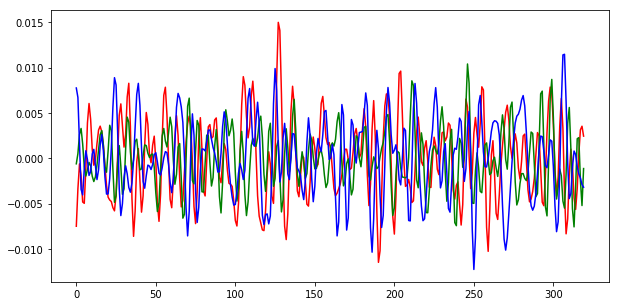

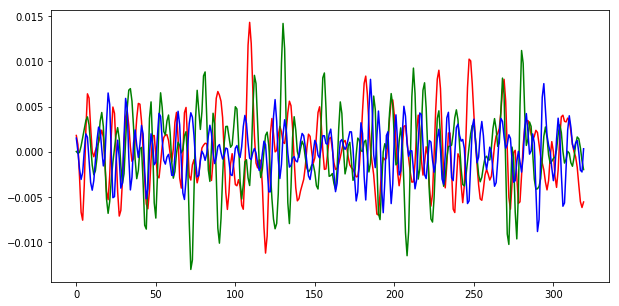

In [27]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][0], c='r')
plt.plot(sample_calss1[10][1], c='g')
plt.plot(sample_calss1[10][2], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2[10][3], c='r')
plt.plot(sample_calss2[10][4], c='g')
plt.plot(sample_calss2[10][0], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3[10][1], c='r')
plt.plot(sample_calss3[10][3], c='g')
plt.plot(sample_calss3[10][4], c='b')
plt.show()

In [28]:
samples_fft = list(fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, freq=FREQ, lowFreq=7, highFreq=30))


In [29]:
len(sample_calss1)

188

In [30]:
len_class_1 = len(sample_calss1)
len_class_2 = len(sample_calss2)
len_class_3 = len(sample_calss3)

sample_calss1_fft = samples_fft[:len_class_1]
sample_calss2_fft = samples_fft[len_class_1:len_class_1 + len_class_2]
sample_calss3_fft = samples_fft[len_class_1 + len_class_2:len_class_1 + len_class_2 + len_class_3]

In [31]:
FIRST_N_FFT = len(sample_calss1_fft[0][0])

In [32]:
FIRST_N_FFT

73

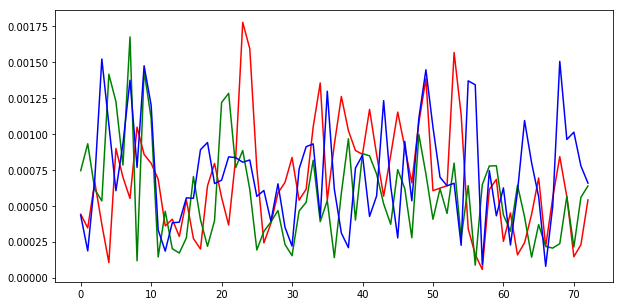

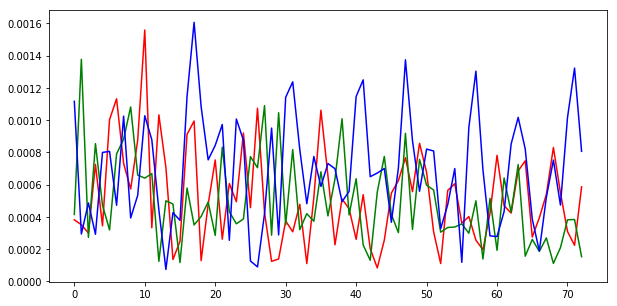

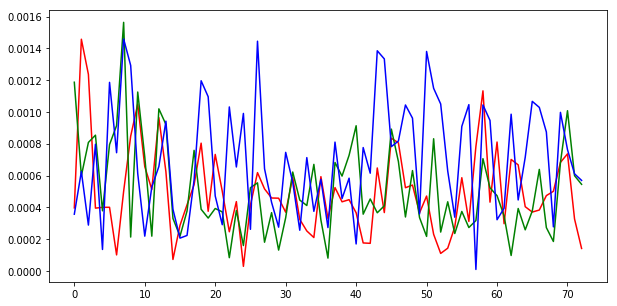

In [33]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft[10][10], c='r')
plt.plot(sample_calss1_fft[10][12], c='g')
plt.plot(sample_calss1_fft[10][13], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft[10][10], c='r')
plt.plot(sample_calss2_fft[10][12], c='g')
plt.plot(sample_calss2_fft[10][13], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft[10][10], c='r')
plt.plot(sample_calss3_fft[10][12], c='g')
plt.plot(sample_calss3_fft[10][13], c='b')
plt.show()

In [34]:
for i in range(len(sample_calss1_fft)):
    for j in range(sample_calss1_fft[0].shape[0]):
        sh = sample_calss1_fft[i][j].shape[0]
        if sh != FIRST_N_FFT:
            print(sh)

In [35]:
#Создание строк для датасета, из матрицы CHANALS*FIRST_N_FFT -> в вектор
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

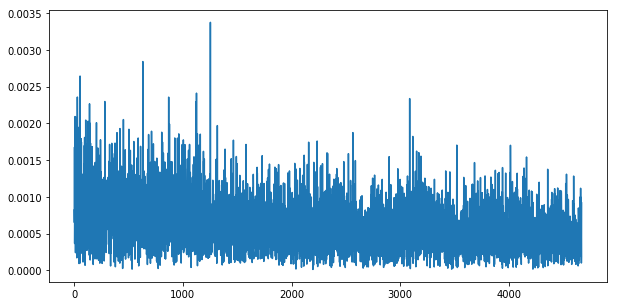

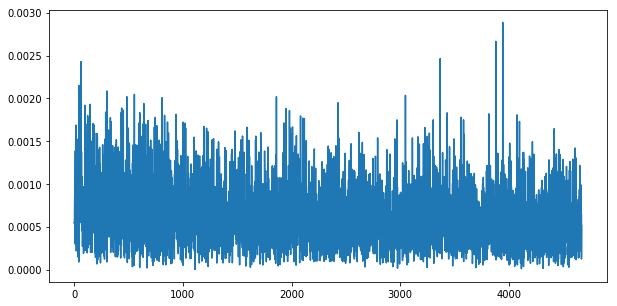

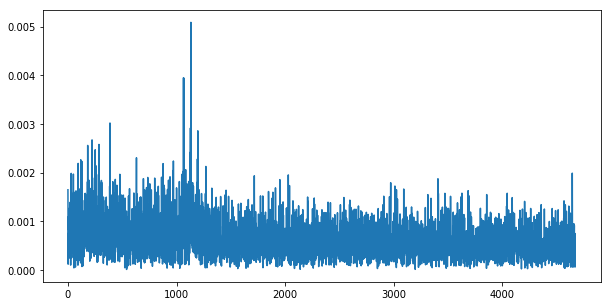

In [36]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft_str[0])
plt.show()

In [37]:
#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class_1, size[0] * FIRST_N_FFT)))
data_class_1['label'] = 1

data_class_1 = np.array(data_class_1)

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class_2 - 3, size[0] * FIRST_N_FFT))) #!!!!!!
data_class_2['label'] = 2

data_class_2 = np.array(data_class_2)

for i in tqdm(range(len(sample_calss2_fft_str) - 3)): #!!!!!!!!!
    data_class_2[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class_3 - 1, size[0] * FIRST_N_FFT))) #####!!!!!!
data_class_3['label'] = 3

data_class_3 = np.array(data_class_3)

for i in tqdm(range(len(sample_calss3_fft_str) - 1)): #####!!!!
    data_class_3[i, :-1] = sample_calss3_fft_str[i]
    

    

data = np.vstack([data_class_1, data_class_2, data_class_3])
data = pd.DataFrame(data)
print(data.shape)

100%|██████████| 98/98 [00:00<00:00, 3910.03it/s]

(370, 4673)


In [38]:
data.columns = [*data.columns[:-1], 'label']

In [39]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    
    features_good = [i for i in features_good if i not in ['[', ']', ',']]
    features_normal = [i for i in features_normal if i not in ['[', ']', ',']]
    features_bad = [i for i in features_bad if i not in ['[', ']', ',']]
    
    features_good = list(map(lambda x: str(x), features_good))
    features_normal = list(map(lambda x: str(x), features_normal))
    features_bad = list(map(lambda x: str(x), features_bad))
    
    
    return features_good, features_normal, features_bad

In [40]:
'''
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}
'''

"\n{'bootstrap': True,\n 'max_depth': 10,\n 'max_features': 'auto',\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'n_estimators': 200}\n"

In [41]:

# ###SOLO

# ## Понизим размерность до 60 компонент
# from sklearn.decomposition import PCA
# PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
# #Стандартизируем матрицу
# # Scaler = StandardScaler()
# # data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# data_standart = (data).iloc[:, :-1]
# # Понижаем размерность
# data_pca = PCA.fit_transform(data_standart)
# data_pca = pd.DataFrame(data_pca)

# # data_pca['label'] = data['label'].values
# labels = data['label'].values

# #Посмотрим важные признаки с помощью RF
# # rf = RandomForestClassifier(bootstrap=True, max_depth=10,
# #                            max_features='auto', min_samples_leaf=1,
# #                            min_samples_split=2, n_estimators=200)
# rf = RandomForestClassifier()
# rf.fit(data_pca, labels)

In [42]:

### ANSAMBEL


## Понизим размерность до 60 компонент
from sklearn.decomposition import PCA
PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
#Стандартизируем матрицу
# Scaler = StandardScaler()
# data_standart = Scaler.fit_transform((data).iloc[:, :-1])
data_standart = (data).iloc[:, :-1]

# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values


fg = []
fn = []
fb = []
for _ in range(20):
    cat = catboost.CatBoostClassifier()
    cat.fit(data_pca, labels)
    feature_importances = pd.DataFrame(cat.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    
    features_good, features_normal, features_bad = scoring_fi(feature_importances)
    fg.extend(features_good)
    fn.extend(features_normal)
    fb.extend(features_bad)

features_good = list(map(lambda x: x[0], sorted(collections.Counter(fg).items(), key=operator.itemgetter(1), reverse=True)[:10]))
features_normal = list(map(lambda x: x[0],
                           sorted(collections.Counter(fn).items(), key=operator.itemgetter(1), reverse=True)))

features_normal = list(set(features_normal) - set(features_good))

features_bad = list(set(fb) - set(features_good) - set(features_normal))

Learning rate set to 0.075214
0:	learn: 1.0744383	total: 84.9ms	remaining: 1m 24s
1:	learn: 1.0604233	total: 97ms	remaining: 48.4s
2:	learn: 1.0309253	total: 109ms	remaining: 36.1s
3:	learn: 1.0052466	total: 120ms	remaining: 30s
4:	learn: 0.9817360	total: 134ms	remaining: 26.6s
5:	learn: 0.9653315	total: 147ms	remaining: 24.3s
6:	learn: 0.9535201	total: 159ms	remaining: 22.5s
7:	learn: 0.9331554	total: 170ms	remaining: 21.1s
8:	learn: 0.9098569	total: 181ms	remaining: 19.9s
9:	learn: 0.8887461	total: 191ms	remaining: 18.9s
10:	learn: 0.8699959	total: 202ms	remaining: 18.1s
11:	learn: 0.8502972	total: 213ms	remaining: 17.5s
12:	learn: 0.8332134	total: 224ms	remaining: 17s
13:	learn: 0.8201230	total: 236ms	remaining: 16.6s
14:	learn: 0.8122820	total: 249ms	remaining: 16.3s
15:	learn: 0.7987595	total: 260ms	remaining: 16s
16:	learn: 0.7849123	total: 270ms	remaining: 15.6s
17:	learn: 0.7732884	total: 280ms	remaining: 15.3s
18:	learn: 0.7624429	total: 290ms	remaining: 15s
19:	learn: 0.75229

169:	learn: 0.1249689	total: 1.92s	remaining: 9.37s
170:	learn: 0.1239324	total: 1.93s	remaining: 9.36s
171:	learn: 0.1227014	total: 1.94s	remaining: 9.35s
172:	learn: 0.1216711	total: 1.95s	remaining: 9.34s
173:	learn: 0.1208050	total: 1.96s	remaining: 9.32s
174:	learn: 0.1195461	total: 1.97s	remaining: 9.31s
175:	learn: 0.1186746	total: 1.98s	remaining: 9.29s
176:	learn: 0.1176593	total: 1.99s	remaining: 9.27s
177:	learn: 0.1164137	total: 2s	remaining: 9.26s
178:	learn: 0.1155503	total: 2.01s	remaining: 9.24s
179:	learn: 0.1141085	total: 2.03s	remaining: 9.23s
180:	learn: 0.1132918	total: 2.04s	remaining: 9.22s
181:	learn: 0.1123196	total: 2.05s	remaining: 9.21s
182:	learn: 0.1114277	total: 2.06s	remaining: 9.19s
183:	learn: 0.1104778	total: 2.07s	remaining: 9.18s
184:	learn: 0.1095434	total: 2.08s	remaining: 9.16s
185:	learn: 0.1088543	total: 2.09s	remaining: 9.14s
186:	learn: 0.1078954	total: 2.1s	remaining: 9.13s
187:	learn: 0.1069487	total: 2.11s	remaining: 9.11s
188:	learn: 0.10

330:	learn: 0.0453024	total: 3.63s	remaining: 7.33s
331:	learn: 0.0451118	total: 3.64s	remaining: 7.32s
332:	learn: 0.0449234	total: 3.65s	remaining: 7.31s
333:	learn: 0.0447029	total: 3.66s	remaining: 7.3s
334:	learn: 0.0443602	total: 3.67s	remaining: 7.29s
335:	learn: 0.0441681	total: 3.68s	remaining: 7.28s
336:	learn: 0.0439645	total: 3.69s	remaining: 7.26s
337:	learn: 0.0437927	total: 3.7s	remaining: 7.25s
338:	learn: 0.0435905	total: 3.71s	remaining: 7.24s
339:	learn: 0.0434085	total: 3.72s	remaining: 7.23s
340:	learn: 0.0432268	total: 3.73s	remaining: 7.22s
341:	learn: 0.0430719	total: 3.75s	remaining: 7.21s
342:	learn: 0.0428909	total: 3.76s	remaining: 7.2s
343:	learn: 0.0427400	total: 3.77s	remaining: 7.19s
344:	learn: 0.0425925	total: 3.78s	remaining: 7.18s
345:	learn: 0.0424000	total: 3.79s	remaining: 7.17s
346:	learn: 0.0422086	total: 3.8s	remaining: 7.16s
347:	learn: 0.0420303	total: 3.81s	remaining: 7.14s
348:	learn: 0.0418211	total: 3.82s	remaining: 7.13s
349:	learn: 0.04

492:	learn: 0.0256512	total: 5.36s	remaining: 5.51s
493:	learn: 0.0255744	total: 5.37s	remaining: 5.5s
494:	learn: 0.0254939	total: 5.38s	remaining: 5.49s
495:	learn: 0.0254209	total: 5.39s	remaining: 5.48s
496:	learn: 0.0253450	total: 5.4s	remaining: 5.47s
497:	learn: 0.0252818	total: 5.41s	remaining: 5.46s
498:	learn: 0.0252323	total: 5.42s	remaining: 5.45s
499:	learn: 0.0251656	total: 5.43s	remaining: 5.43s
500:	learn: 0.0250817	total: 5.44s	remaining: 5.42s
501:	learn: 0.0250027	total: 5.45s	remaining: 5.41s
502:	learn: 0.0249272	total: 5.47s	remaining: 5.4s
503:	learn: 0.0248582	total: 5.48s	remaining: 5.39s
504:	learn: 0.0247879	total: 5.49s	remaining: 5.38s
505:	learn: 0.0247285	total: 5.5s	remaining: 5.37s
506:	learn: 0.0246617	total: 5.51s	remaining: 5.36s
507:	learn: 0.0245542	total: 5.52s	remaining: 5.34s
508:	learn: 0.0244622	total: 5.53s	remaining: 5.33s
509:	learn: 0.0243862	total: 5.54s	remaining: 5.32s
510:	learn: 0.0243053	total: 5.55s	remaining: 5.31s
511:	learn: 0.02

653:	learn: 0.0171127	total: 7.06s	remaining: 3.73s
654:	learn: 0.0170845	total: 7.07s	remaining: 3.72s
655:	learn: 0.0170550	total: 7.08s	remaining: 3.71s
656:	learn: 0.0170146	total: 7.09s	remaining: 3.7s
657:	learn: 0.0169872	total: 7.1s	remaining: 3.69s
658:	learn: 0.0169649	total: 7.11s	remaining: 3.68s
659:	learn: 0.0169351	total: 7.12s	remaining: 3.67s
660:	learn: 0.0169059	total: 7.13s	remaining: 3.66s
661:	learn: 0.0168687	total: 7.14s	remaining: 3.65s
662:	learn: 0.0168305	total: 7.15s	remaining: 3.64s
663:	learn: 0.0167939	total: 7.17s	remaining: 3.63s
664:	learn: 0.0167703	total: 7.18s	remaining: 3.62s
665:	learn: 0.0167442	total: 7.19s	remaining: 3.6s
666:	learn: 0.0167134	total: 7.2s	remaining: 3.59s
667:	learn: 0.0166838	total: 7.21s	remaining: 3.58s
668:	learn: 0.0166470	total: 7.22s	remaining: 3.57s
669:	learn: 0.0166067	total: 7.23s	remaining: 3.56s
670:	learn: 0.0165812	total: 7.24s	remaining: 3.55s
671:	learn: 0.0165395	total: 7.25s	remaining: 3.54s
672:	learn: 0.01

815:	learn: 0.0127765	total: 8.77s	remaining: 1.98s
816:	learn: 0.0127575	total: 8.78s	remaining: 1.97s
817:	learn: 0.0127387	total: 8.79s	remaining: 1.96s
818:	learn: 0.0127196	total: 8.8s	remaining: 1.95s
819:	learn: 0.0126973	total: 8.81s	remaining: 1.94s
820:	learn: 0.0126613	total: 8.82s	remaining: 1.92s
821:	learn: 0.0126455	total: 8.84s	remaining: 1.91s
822:	learn: 0.0126209	total: 8.85s	remaining: 1.9s
823:	learn: 0.0126046	total: 8.86s	remaining: 1.89s
824:	learn: 0.0125878	total: 8.87s	remaining: 1.88s
825:	learn: 0.0125691	total: 8.88s	remaining: 1.87s
826:	learn: 0.0125523	total: 8.89s	remaining: 1.86s
827:	learn: 0.0125316	total: 8.9s	remaining: 1.85s
828:	learn: 0.0125079	total: 8.91s	remaining: 1.84s
829:	learn: 0.0124933	total: 8.92s	remaining: 1.83s
830:	learn: 0.0124749	total: 8.93s	remaining: 1.82s
831:	learn: 0.0124503	total: 8.94s	remaining: 1.8s
832:	learn: 0.0124315	total: 8.95s	remaining: 1.79s
833:	learn: 0.0124171	total: 8.96s	remaining: 1.78s
834:	learn: 0.01

976:	learn: 0.0100932	total: 10.5s	remaining: 246ms
977:	learn: 0.0100757	total: 10.5s	remaining: 236ms
978:	learn: 0.0100620	total: 10.5s	remaining: 225ms
979:	learn: 0.0100426	total: 10.5s	remaining: 214ms
980:	learn: 0.0100243	total: 10.5s	remaining: 204ms
981:	learn: 0.0100112	total: 10.5s	remaining: 193ms
982:	learn: 0.0100002	total: 10.5s	remaining: 182ms
983:	learn: 0.0099856	total: 10.5s	remaining: 171ms
984:	learn: 0.0099661	total: 10.6s	remaining: 161ms
985:	learn: 0.0099576	total: 10.6s	remaining: 150ms
986:	learn: 0.0099471	total: 10.6s	remaining: 139ms
987:	learn: 0.0099384	total: 10.6s	remaining: 129ms
988:	learn: 0.0099243	total: 10.6s	remaining: 118ms
989:	learn: 0.0099098	total: 10.6s	remaining: 107ms
990:	learn: 0.0098948	total: 10.6s	remaining: 96.5ms
991:	learn: 0.0098822	total: 10.6s	remaining: 85.7ms
992:	learn: 0.0098710	total: 10.6s	remaining: 75ms
993:	learn: 0.0098578	total: 10.7s	remaining: 64.3ms
994:	learn: 0.0098423	total: 10.7s	remaining: 53.6ms
995:	lear

143:	learn: 0.1602265	total: 1.53s	remaining: 9.11s
144:	learn: 0.1587886	total: 1.54s	remaining: 9.1s
145:	learn: 0.1569544	total: 1.55s	remaining: 9.09s
146:	learn: 0.1551198	total: 1.56s	remaining: 9.08s
147:	learn: 0.1537015	total: 1.57s	remaining: 9.07s
148:	learn: 0.1526375	total: 1.58s	remaining: 9.06s
149:	learn: 0.1511946	total: 1.59s	remaining: 9.04s
150:	learn: 0.1494548	total: 1.61s	remaining: 9.03s
151:	learn: 0.1479446	total: 1.62s	remaining: 9.02s
152:	learn: 0.1463967	total: 1.63s	remaining: 9s
153:	learn: 0.1448375	total: 1.64s	remaining: 8.99s
154:	learn: 0.1435646	total: 1.65s	remaining: 8.97s
155:	learn: 0.1420185	total: 1.66s	remaining: 8.97s
156:	learn: 0.1408367	total: 1.67s	remaining: 8.96s
157:	learn: 0.1395355	total: 1.68s	remaining: 8.95s
158:	learn: 0.1382660	total: 1.69s	remaining: 8.94s
159:	learn: 0.1370367	total: 1.7s	remaining: 8.92s
160:	learn: 0.1356764	total: 1.71s	remaining: 8.91s
161:	learn: 0.1342547	total: 1.72s	remaining: 8.9s
162:	learn: 0.1330

306:	learn: 0.0503587	total: 3.25s	remaining: 7.34s
307:	learn: 0.0501501	total: 3.26s	remaining: 7.33s
308:	learn: 0.0499373	total: 3.28s	remaining: 7.33s
309:	learn: 0.0497215	total: 3.29s	remaining: 7.32s
310:	learn: 0.0495294	total: 3.3s	remaining: 7.31s
311:	learn: 0.0493160	total: 3.31s	remaining: 7.3s
312:	learn: 0.0490775	total: 3.32s	remaining: 7.29s
313:	learn: 0.0488056	total: 3.33s	remaining: 7.27s
314:	learn: 0.0486252	total: 3.34s	remaining: 7.26s
315:	learn: 0.0484216	total: 3.35s	remaining: 7.25s
316:	learn: 0.0481347	total: 3.36s	remaining: 7.25s
317:	learn: 0.0479621	total: 3.38s	remaining: 7.24s
318:	learn: 0.0477284	total: 3.39s	remaining: 7.23s
319:	learn: 0.0475456	total: 3.4s	remaining: 7.22s
320:	learn: 0.0473603	total: 3.41s	remaining: 7.21s
321:	learn: 0.0471670	total: 3.42s	remaining: 7.19s
322:	learn: 0.0469181	total: 3.43s	remaining: 7.18s
323:	learn: 0.0467478	total: 3.44s	remaining: 7.17s
324:	learn: 0.0465741	total: 3.45s	remaining: 7.16s
325:	learn: 0.0

465:	learn: 0.0277367	total: 4.95s	remaining: 5.67s
466:	learn: 0.0276373	total: 4.96s	remaining: 5.66s
467:	learn: 0.0275483	total: 4.97s	remaining: 5.65s
468:	learn: 0.0274839	total: 4.98s	remaining: 5.64s
469:	learn: 0.0274054	total: 4.99s	remaining: 5.63s
470:	learn: 0.0273045	total: 5s	remaining: 5.62s
471:	learn: 0.0272371	total: 5.01s	remaining: 5.61s
472:	learn: 0.0271520	total: 5.03s	remaining: 5.6s
473:	learn: 0.0270649	total: 5.04s	remaining: 5.59s
474:	learn: 0.0269952	total: 5.04s	remaining: 5.58s
475:	learn: 0.0269178	total: 5.05s	remaining: 5.57s
476:	learn: 0.0268148	total: 5.07s	remaining: 5.55s
477:	learn: 0.0267536	total: 5.08s	remaining: 5.54s
478:	learn: 0.0266659	total: 5.09s	remaining: 5.54s
479:	learn: 0.0266000	total: 5.1s	remaining: 5.52s
480:	learn: 0.0265060	total: 5.11s	remaining: 5.51s
481:	learn: 0.0264392	total: 5.12s	remaining: 5.5s
482:	learn: 0.0263393	total: 5.13s	remaining: 5.49s
483:	learn: 0.0262776	total: 5.14s	remaining: 5.48s
484:	learn: 0.0262

628:	learn: 0.0180715	total: 6.67s	remaining: 3.94s
629:	learn: 0.0180084	total: 6.68s	remaining: 3.93s
630:	learn: 0.0179678	total: 6.7s	remaining: 3.92s
631:	learn: 0.0179389	total: 6.71s	remaining: 3.9s
632:	learn: 0.0179093	total: 6.72s	remaining: 3.9s
633:	learn: 0.0178523	total: 6.73s	remaining: 3.88s
634:	learn: 0.0178106	total: 6.74s	remaining: 3.87s
635:	learn: 0.0177727	total: 6.75s	remaining: 3.86s
636:	learn: 0.0177352	total: 6.76s	remaining: 3.85s
637:	learn: 0.0177027	total: 6.77s	remaining: 3.84s
638:	learn: 0.0176427	total: 6.78s	remaining: 3.83s
639:	learn: 0.0176066	total: 6.79s	remaining: 3.82s
640:	learn: 0.0175608	total: 6.8s	remaining: 3.81s
641:	learn: 0.0175118	total: 6.81s	remaining: 3.8s
642:	learn: 0.0174835	total: 6.83s	remaining: 3.79s
643:	learn: 0.0174525	total: 6.83s	remaining: 3.78s
644:	learn: 0.0174230	total: 6.84s	remaining: 3.77s
645:	learn: 0.0173898	total: 6.86s	remaining: 3.76s
646:	learn: 0.0173449	total: 6.87s	remaining: 3.75s
647:	learn: 0.017

788:	learn: 0.0133510	total: 8.37s	remaining: 2.24s
789:	learn: 0.0133282	total: 8.38s	remaining: 2.23s
790:	learn: 0.0133006	total: 8.39s	remaining: 2.22s
791:	learn: 0.0132777	total: 8.4s	remaining: 2.21s
792:	learn: 0.0132488	total: 8.41s	remaining: 2.2s
793:	learn: 0.0132292	total: 8.42s	remaining: 2.19s
794:	learn: 0.0131933	total: 8.43s	remaining: 2.17s
795:	learn: 0.0131711	total: 8.44s	remaining: 2.16s
796:	learn: 0.0131545	total: 8.45s	remaining: 2.15s
797:	learn: 0.0131390	total: 8.46s	remaining: 2.14s
798:	learn: 0.0131197	total: 8.47s	remaining: 2.13s
799:	learn: 0.0130959	total: 8.48s	remaining: 2.12s
800:	learn: 0.0130762	total: 8.5s	remaining: 2.11s
801:	learn: 0.0130595	total: 8.51s	remaining: 2.1s
802:	learn: 0.0130450	total: 8.52s	remaining: 2.09s
803:	learn: 0.0130236	total: 8.53s	remaining: 2.08s
804:	learn: 0.0130005	total: 8.54s	remaining: 2.07s
805:	learn: 0.0129823	total: 8.55s	remaining: 2.06s
806:	learn: 0.0129640	total: 8.56s	remaining: 2.05s
807:	learn: 0.01

951:	learn: 0.0104173	total: 10.1s	remaining: 509ms
952:	learn: 0.0104042	total: 10.1s	remaining: 498ms
953:	learn: 0.0103936	total: 10.1s	remaining: 488ms
954:	learn: 0.0103795	total: 10.1s	remaining: 477ms
955:	learn: 0.0103633	total: 10.1s	remaining: 467ms
956:	learn: 0.0103491	total: 10.1s	remaining: 456ms
957:	learn: 0.0103366	total: 10.2s	remaining: 445ms
958:	learn: 0.0103250	total: 10.2s	remaining: 435ms
959:	learn: 0.0103103	total: 10.2s	remaining: 424ms
960:	learn: 0.0102984	total: 10.2s	remaining: 414ms
961:	learn: 0.0102854	total: 10.2s	remaining: 403ms
962:	learn: 0.0102703	total: 10.2s	remaining: 392ms
963:	learn: 0.0102522	total: 10.2s	remaining: 382ms
964:	learn: 0.0102404	total: 10.2s	remaining: 371ms
965:	learn: 0.0102308	total: 10.2s	remaining: 361ms
966:	learn: 0.0102193	total: 10.3s	remaining: 350ms
967:	learn: 0.0102064	total: 10.3s	remaining: 339ms
968:	learn: 0.0101910	total: 10.3s	remaining: 329ms
969:	learn: 0.0101796	total: 10.3s	remaining: 318ms
970:	learn: 

118:	learn: 0.2067580	total: 1.26s	remaining: 9.32s
119:	learn: 0.2042869	total: 1.27s	remaining: 9.32s
120:	learn: 0.2018274	total: 1.28s	remaining: 9.31s
121:	learn: 0.1998680	total: 1.29s	remaining: 9.31s
122:	learn: 0.1977728	total: 1.3s	remaining: 9.29s
123:	learn: 0.1952810	total: 1.31s	remaining: 9.28s
124:	learn: 0.1931834	total: 1.32s	remaining: 9.27s
125:	learn: 0.1910442	total: 1.33s	remaining: 9.25s
126:	learn: 0.1889202	total: 1.34s	remaining: 9.24s
127:	learn: 0.1866510	total: 1.36s	remaining: 9.24s
128:	learn: 0.1843969	total: 1.37s	remaining: 9.24s
129:	learn: 0.1824935	total: 1.38s	remaining: 9.22s
130:	learn: 0.1807244	total: 1.39s	remaining: 9.21s
131:	learn: 0.1789901	total: 1.4s	remaining: 9.2s
132:	learn: 0.1773834	total: 1.41s	remaining: 9.19s
133:	learn: 0.1758537	total: 1.42s	remaining: 9.17s
134:	learn: 0.1739707	total: 1.43s	remaining: 9.16s
135:	learn: 0.1723204	total: 1.44s	remaining: 9.15s
136:	learn: 0.1706939	total: 1.45s	remaining: 9.14s
137:	learn: 0.1

278:	learn: 0.0583792	total: 2.96s	remaining: 7.64s
279:	learn: 0.0581007	total: 2.97s	remaining: 7.63s
280:	learn: 0.0578048	total: 2.98s	remaining: 7.62s
281:	learn: 0.0574914	total: 2.99s	remaining: 7.61s
282:	learn: 0.0570617	total: 3s	remaining: 7.6s
283:	learn: 0.0567962	total: 3.01s	remaining: 7.59s
284:	learn: 0.0564988	total: 3.02s	remaining: 7.58s
285:	learn: 0.0561557	total: 3.03s	remaining: 7.56s
286:	learn: 0.0558344	total: 3.04s	remaining: 7.55s
287:	learn: 0.0555406	total: 3.05s	remaining: 7.54s
288:	learn: 0.0552704	total: 3.06s	remaining: 7.53s
289:	learn: 0.0549292	total: 3.07s	remaining: 7.52s
290:	learn: 0.0546091	total: 3.08s	remaining: 7.51s
291:	learn: 0.0542908	total: 3.09s	remaining: 7.5s
292:	learn: 0.0540030	total: 3.1s	remaining: 7.49s
293:	learn: 0.0537598	total: 3.12s	remaining: 7.48s
294:	learn: 0.0535351	total: 3.13s	remaining: 7.47s
295:	learn: 0.0533255	total: 3.14s	remaining: 7.46s
296:	learn: 0.0529840	total: 3.15s	remaining: 7.45s
297:	learn: 0.0527

441:	learn: 0.0299158	total: 4.68s	remaining: 5.91s
442:	learn: 0.0298371	total: 4.69s	remaining: 5.9s
443:	learn: 0.0297473	total: 4.7s	remaining: 5.89s
444:	learn: 0.0296499	total: 4.71s	remaining: 5.88s
445:	learn: 0.0295642	total: 4.72s	remaining: 5.87s
446:	learn: 0.0294846	total: 4.73s	remaining: 5.85s
447:	learn: 0.0293934	total: 4.74s	remaining: 5.84s
448:	learn: 0.0292863	total: 4.75s	remaining: 5.83s
449:	learn: 0.0291859	total: 4.76s	remaining: 5.82s
450:	learn: 0.0291068	total: 4.77s	remaining: 5.81s
451:	learn: 0.0290035	total: 4.78s	remaining: 5.8s
452:	learn: 0.0289195	total: 4.79s	remaining: 5.79s
453:	learn: 0.0288095	total: 4.8s	remaining: 5.78s
454:	learn: 0.0287379	total: 4.82s	remaining: 5.77s
455:	learn: 0.0286423	total: 4.83s	remaining: 5.76s
456:	learn: 0.0285575	total: 4.83s	remaining: 5.75s
457:	learn: 0.0284654	total: 4.84s	remaining: 5.73s
458:	learn: 0.0283656	total: 4.86s	remaining: 5.72s
459:	learn: 0.0282603	total: 4.87s	remaining: 5.71s
460:	learn: 0.02

601:	learn: 0.0192383	total: 6.38s	remaining: 4.21s
602:	learn: 0.0191843	total: 6.39s	remaining: 4.2s
603:	learn: 0.0191359	total: 6.4s	remaining: 4.19s
604:	learn: 0.0190860	total: 6.41s	remaining: 4.18s
605:	learn: 0.0190459	total: 6.42s	remaining: 4.17s
606:	learn: 0.0189834	total: 6.43s	remaining: 4.16s
607:	learn: 0.0189512	total: 6.44s	remaining: 4.15s
608:	learn: 0.0189042	total: 6.45s	remaining: 4.14s
609:	learn: 0.0188519	total: 6.46s	remaining: 4.13s
610:	learn: 0.0188112	total: 6.47s	remaining: 4.12s
611:	learn: 0.0187689	total: 6.48s	remaining: 4.11s
612:	learn: 0.0187297	total: 6.49s	remaining: 4.1s
613:	learn: 0.0186851	total: 6.5s	remaining: 4.09s
614:	learn: 0.0186279	total: 6.51s	remaining: 4.08s
615:	learn: 0.0185766	total: 6.52s	remaining: 4.07s
616:	learn: 0.0185397	total: 6.53s	remaining: 4.05s
617:	learn: 0.0185007	total: 6.54s	remaining: 4.04s
618:	learn: 0.0184561	total: 6.55s	remaining: 4.03s
619:	learn: 0.0184035	total: 6.56s	remaining: 4.02s
620:	learn: 0.01

764:	learn: 0.0139024	total: 8.1s	remaining: 2.49s
765:	learn: 0.0138802	total: 8.11s	remaining: 2.48s
766:	learn: 0.0138580	total: 8.12s	remaining: 2.47s
767:	learn: 0.0138382	total: 8.13s	remaining: 2.46s
768:	learn: 0.0138124	total: 8.14s	remaining: 2.44s
769:	learn: 0.0137909	total: 8.15s	remaining: 2.44s
770:	learn: 0.0137680	total: 8.16s	remaining: 2.42s
771:	learn: 0.0137489	total: 8.17s	remaining: 2.41s
772:	learn: 0.0137316	total: 8.18s	remaining: 2.4s
773:	learn: 0.0137046	total: 8.19s	remaining: 2.39s
774:	learn: 0.0136707	total: 8.21s	remaining: 2.38s
775:	learn: 0.0136460	total: 8.22s	remaining: 2.37s
776:	learn: 0.0136239	total: 8.23s	remaining: 2.36s
777:	learn: 0.0135968	total: 8.24s	remaining: 2.35s
778:	learn: 0.0135684	total: 8.25s	remaining: 2.34s
779:	learn: 0.0135400	total: 8.26s	remaining: 2.33s
780:	learn: 0.0135188	total: 8.27s	remaining: 2.32s
781:	learn: 0.0135023	total: 8.28s	remaining: 2.31s
782:	learn: 0.0134824	total: 8.29s	remaining: 2.3s
783:	learn: 0.0

924:	learn: 0.0108223	total: 9.79s	remaining: 794ms
925:	learn: 0.0107996	total: 9.8s	remaining: 783ms
926:	learn: 0.0107807	total: 9.81s	remaining: 773ms
927:	learn: 0.0107658	total: 9.82s	remaining: 762ms
928:	learn: 0.0107487	total: 9.83s	remaining: 752ms
929:	learn: 0.0107346	total: 9.85s	remaining: 741ms
930:	learn: 0.0107169	total: 9.86s	remaining: 731ms
931:	learn: 0.0107045	total: 9.87s	remaining: 720ms
932:	learn: 0.0106916	total: 9.88s	remaining: 709ms
933:	learn: 0.0106763	total: 9.89s	remaining: 699ms
934:	learn: 0.0106619	total: 9.9s	remaining: 688ms
935:	learn: 0.0106452	total: 9.91s	remaining: 678ms
936:	learn: 0.0106286	total: 9.92s	remaining: 667ms
937:	learn: 0.0106111	total: 9.93s	remaining: 656ms
938:	learn: 0.0105972	total: 9.94s	remaining: 646ms
939:	learn: 0.0105745	total: 9.95s	remaining: 635ms
940:	learn: 0.0105635	total: 9.96s	remaining: 625ms
941:	learn: 0.0105520	total: 9.97s	remaining: 614ms
942:	learn: 0.0105370	total: 9.98s	remaining: 603ms
943:	learn: 0.

84:	learn: 0.3158278	total: 906ms	remaining: 9.76s
85:	learn: 0.3117036	total: 917ms	remaining: 9.75s
86:	learn: 0.3080874	total: 929ms	remaining: 9.75s
87:	learn: 0.3044126	total: 940ms	remaining: 9.74s
88:	learn: 0.3007185	total: 951ms	remaining: 9.73s
89:	learn: 0.2970790	total: 961ms	remaining: 9.71s
90:	learn: 0.2929580	total: 971ms	remaining: 9.7s
91:	learn: 0.2898057	total: 981ms	remaining: 9.68s
92:	learn: 0.2862015	total: 991ms	remaining: 9.66s
93:	learn: 0.2828827	total: 1s	remaining: 9.65s
94:	learn: 0.2802433	total: 1.01s	remaining: 9.65s
95:	learn: 0.2763004	total: 1.02s	remaining: 9.65s
96:	learn: 0.2725926	total: 1.03s	remaining: 9.64s
97:	learn: 0.2690722	total: 1.04s	remaining: 9.62s
98:	learn: 0.2654481	total: 1.05s	remaining: 9.61s
99:	learn: 0.2615126	total: 1.06s	remaining: 9.59s
100:	learn: 0.2585802	total: 1.08s	remaining: 9.58s
101:	learn: 0.2551344	total: 1.08s	remaining: 9.56s
102:	learn: 0.2518723	total: 1.09s	remaining: 9.54s
103:	learn: 0.2486387	total: 1.1

245:	learn: 0.0705377	total: 2.62s	remaining: 8.03s
246:	learn: 0.0700933	total: 2.63s	remaining: 8.02s
247:	learn: 0.0696740	total: 2.64s	remaining: 8.01s
248:	learn: 0.0692602	total: 2.65s	remaining: 8s
249:	learn: 0.0689451	total: 2.66s	remaining: 7.99s
250:	learn: 0.0683358	total: 2.67s	remaining: 7.98s
251:	learn: 0.0678972	total: 2.69s	remaining: 7.97s
252:	learn: 0.0675395	total: 2.69s	remaining: 7.96s
253:	learn: 0.0671448	total: 2.71s	remaining: 7.95s
254:	learn: 0.0667395	total: 2.72s	remaining: 7.94s
255:	learn: 0.0663580	total: 2.73s	remaining: 7.93s
256:	learn: 0.0660286	total: 2.74s	remaining: 7.92s
257:	learn: 0.0656836	total: 2.75s	remaining: 7.91s
258:	learn: 0.0652145	total: 2.76s	remaining: 7.9s
259:	learn: 0.0648466	total: 2.77s	remaining: 7.88s
260:	learn: 0.0644659	total: 2.78s	remaining: 7.87s
261:	learn: 0.0640950	total: 2.79s	remaining: 7.86s
262:	learn: 0.0636831	total: 2.8s	remaining: 7.85s
263:	learn: 0.0632728	total: 2.81s	remaining: 7.84s
264:	learn: 0.062

413:	learn: 0.0328439	total: 4.44s	remaining: 6.28s
414:	learn: 0.0327452	total: 4.45s	remaining: 6.27s
415:	learn: 0.0326400	total: 4.46s	remaining: 6.26s
416:	learn: 0.0325508	total: 4.47s	remaining: 6.25s
417:	learn: 0.0324407	total: 4.48s	remaining: 6.24s
418:	learn: 0.0323254	total: 4.5s	remaining: 6.24s
419:	learn: 0.0322188	total: 4.51s	remaining: 6.23s
420:	learn: 0.0320719	total: 4.52s	remaining: 6.22s
421:	learn: 0.0319874	total: 4.54s	remaining: 6.21s
422:	learn: 0.0318703	total: 4.55s	remaining: 6.21s
423:	learn: 0.0317915	total: 4.56s	remaining: 6.2s
424:	learn: 0.0317253	total: 4.57s	remaining: 6.18s
425:	learn: 0.0316184	total: 4.58s	remaining: 6.17s
426:	learn: 0.0314882	total: 4.59s	remaining: 6.16s
427:	learn: 0.0313887	total: 4.6s	remaining: 6.15s
428:	learn: 0.0312794	total: 4.61s	remaining: 6.14s
429:	learn: 0.0311517	total: 4.62s	remaining: 6.13s
430:	learn: 0.0310484	total: 4.63s	remaining: 6.11s
431:	learn: 0.0309450	total: 4.64s	remaining: 6.1s
432:	learn: 0.03

581:	learn: 0.0201407	total: 6.26s	remaining: 4.5s
582:	learn: 0.0200978	total: 6.27s	remaining: 4.49s
583:	learn: 0.0200529	total: 6.28s	remaining: 4.47s
584:	learn: 0.0199987	total: 6.29s	remaining: 4.46s
585:	learn: 0.0199613	total: 6.3s	remaining: 4.45s
586:	learn: 0.0199285	total: 6.31s	remaining: 4.44s
587:	learn: 0.0198882	total: 6.33s	remaining: 4.43s
588:	learn: 0.0198402	total: 6.33s	remaining: 4.42s
589:	learn: 0.0197900	total: 6.35s	remaining: 4.41s
590:	learn: 0.0197480	total: 6.36s	remaining: 4.4s
591:	learn: 0.0196821	total: 6.37s	remaining: 4.39s
592:	learn: 0.0196340	total: 6.38s	remaining: 4.38s
593:	learn: 0.0195915	total: 6.39s	remaining: 4.37s
594:	learn: 0.0195649	total: 6.4s	remaining: 4.36s
595:	learn: 0.0195086	total: 6.41s	remaining: 4.34s
596:	learn: 0.0194738	total: 6.42s	remaining: 4.33s
597:	learn: 0.0194391	total: 6.43s	remaining: 4.32s
598:	learn: 0.0193889	total: 6.44s	remaining: 4.31s
599:	learn: 0.0193485	total: 6.45s	remaining: 4.3s
600:	learn: 0.019

740:	learn: 0.0144583	total: 7.94s	remaining: 2.77s
741:	learn: 0.0144357	total: 7.95s	remaining: 2.77s
742:	learn: 0.0144158	total: 7.96s	remaining: 2.75s
743:	learn: 0.0143953	total: 7.98s	remaining: 2.74s
744:	learn: 0.0143670	total: 7.99s	remaining: 2.73s
745:	learn: 0.0143473	total: 8s	remaining: 2.72s
746:	learn: 0.0143179	total: 8.01s	remaining: 2.71s
747:	learn: 0.0142996	total: 8.02s	remaining: 2.7s
748:	learn: 0.0142776	total: 8.03s	remaining: 2.69s
749:	learn: 0.0142499	total: 8.04s	remaining: 2.68s
750:	learn: 0.0142202	total: 8.05s	remaining: 2.67s
751:	learn: 0.0141974	total: 8.06s	remaining: 2.66s
752:	learn: 0.0141798	total: 8.07s	remaining: 2.65s
753:	learn: 0.0141570	total: 8.08s	remaining: 2.64s
754:	learn: 0.0141328	total: 8.09s	remaining: 2.63s
755:	learn: 0.0141117	total: 8.1s	remaining: 2.62s
756:	learn: 0.0140939	total: 8.11s	remaining: 2.6s
757:	learn: 0.0140671	total: 8.12s	remaining: 2.59s
758:	learn: 0.0140430	total: 8.13s	remaining: 2.58s
759:	learn: 0.0140

903:	learn: 0.0111373	total: 9.67s	remaining: 1.03s
904:	learn: 0.0111221	total: 9.68s	remaining: 1.02s
905:	learn: 0.0111033	total: 9.7s	remaining: 1.01s
906:	learn: 0.0110907	total: 9.71s	remaining: 995ms
907:	learn: 0.0110739	total: 9.72s	remaining: 985ms
908:	learn: 0.0110574	total: 9.73s	remaining: 974ms
909:	learn: 0.0110427	total: 9.74s	remaining: 963ms
910:	learn: 0.0110270	total: 9.75s	remaining: 952ms
911:	learn: 0.0110107	total: 9.76s	remaining: 942ms
912:	learn: 0.0110004	total: 9.77s	remaining: 931ms
913:	learn: 0.0109852	total: 9.78s	remaining: 920ms
914:	learn: 0.0109711	total: 9.79s	remaining: 910ms
915:	learn: 0.0109566	total: 9.8s	remaining: 899ms
916:	learn: 0.0109418	total: 9.81s	remaining: 888ms
917:	learn: 0.0109307	total: 9.82s	remaining: 877ms
918:	learn: 0.0109087	total: 9.83s	remaining: 867ms
919:	learn: 0.0108961	total: 9.84s	remaining: 856ms
920:	learn: 0.0108831	total: 9.85s	remaining: 845ms
921:	learn: 0.0108667	total: 9.86s	remaining: 834ms
922:	learn: 0.

71:	learn: 0.3676634	total: 765ms	remaining: 9.85s
72:	learn: 0.3646616	total: 776ms	remaining: 9.85s
73:	learn: 0.3606696	total: 787ms	remaining: 9.85s
74:	learn: 0.3562230	total: 798ms	remaining: 9.84s
75:	learn: 0.3522614	total: 809ms	remaining: 9.83s
76:	learn: 0.3477165	total: 819ms	remaining: 9.81s
77:	learn: 0.3438240	total: 829ms	remaining: 9.8s
78:	learn: 0.3398680	total: 839ms	remaining: 9.78s
79:	learn: 0.3359943	total: 851ms	remaining: 9.78s
80:	learn: 0.3323835	total: 862ms	remaining: 9.78s
81:	learn: 0.3280273	total: 873ms	remaining: 9.77s
82:	learn: 0.3242787	total: 883ms	remaining: 9.76s
83:	learn: 0.3201036	total: 893ms	remaining: 9.74s
84:	learn: 0.3158278	total: 904ms	remaining: 9.72s
85:	learn: 0.3117036	total: 913ms	remaining: 9.71s
86:	learn: 0.3080874	total: 923ms	remaining: 9.69s
87:	learn: 0.3044126	total: 933ms	remaining: 9.67s
88:	learn: 0.3007185	total: 944ms	remaining: 9.66s
89:	learn: 0.2970790	total: 955ms	remaining: 9.65s
90:	learn: 0.2929580	total: 967m

230:	learn: 0.0778539	total: 2.45s	remaining: 8.15s
231:	learn: 0.0773399	total: 2.46s	remaining: 8.14s
232:	learn: 0.0768709	total: 2.47s	remaining: 8.13s
233:	learn: 0.0763102	total: 2.48s	remaining: 8.13s
234:	learn: 0.0758432	total: 2.49s	remaining: 8.12s
235:	learn: 0.0753504	total: 2.5s	remaining: 8.1s
236:	learn: 0.0747142	total: 2.51s	remaining: 8.09s
237:	learn: 0.0740722	total: 2.52s	remaining: 8.08s
238:	learn: 0.0736551	total: 2.54s	remaining: 8.07s
239:	learn: 0.0732140	total: 2.54s	remaining: 8.06s
240:	learn: 0.0727038	total: 2.56s	remaining: 8.05s
241:	learn: 0.0722522	total: 2.57s	remaining: 8.04s
242:	learn: 0.0716969	total: 2.58s	remaining: 8.03s
243:	learn: 0.0712718	total: 2.59s	remaining: 8.02s
244:	learn: 0.0709113	total: 2.6s	remaining: 8.01s
245:	learn: 0.0705377	total: 2.61s	remaining: 8s
246:	learn: 0.0700933	total: 2.62s	remaining: 7.99s
247:	learn: 0.0696740	total: 2.63s	remaining: 7.98s
248:	learn: 0.0692602	total: 2.64s	remaining: 7.97s
249:	learn: 0.0689

394:	learn: 0.0351417	total: 4.19s	remaining: 6.41s
395:	learn: 0.0350161	total: 4.2s	remaining: 6.4s
396:	learn: 0.0348939	total: 4.21s	remaining: 6.39s
397:	learn: 0.0347773	total: 4.22s	remaining: 6.38s
398:	learn: 0.0346719	total: 4.23s	remaining: 6.37s
399:	learn: 0.0345123	total: 4.24s	remaining: 6.36s
400:	learn: 0.0343889	total: 4.25s	remaining: 6.35s
401:	learn: 0.0342441	total: 4.26s	remaining: 6.34s
402:	learn: 0.0341202	total: 4.28s	remaining: 6.33s
403:	learn: 0.0339749	total: 4.29s	remaining: 6.32s
404:	learn: 0.0338688	total: 4.29s	remaining: 6.31s
405:	learn: 0.0337449	total: 4.31s	remaining: 6.3s
406:	learn: 0.0336454	total: 4.32s	remaining: 6.29s
407:	learn: 0.0335209	total: 4.33s	remaining: 6.28s
408:	learn: 0.0334101	total: 4.34s	remaining: 6.27s
409:	learn: 0.0333048	total: 4.35s	remaining: 6.25s
410:	learn: 0.0332039	total: 4.36s	remaining: 6.24s
411:	learn: 0.0330859	total: 4.37s	remaining: 6.23s
412:	learn: 0.0329667	total: 4.38s	remaining: 6.22s
413:	learn: 0.0

553:	learn: 0.0216332	total: 5.87s	remaining: 4.73s
554:	learn: 0.0215607	total: 5.88s	remaining: 4.72s
555:	learn: 0.0215060	total: 5.89s	remaining: 4.71s
556:	learn: 0.0214527	total: 5.91s	remaining: 4.7s
557:	learn: 0.0213909	total: 5.92s	remaining: 4.69s
558:	learn: 0.0213407	total: 5.93s	remaining: 4.67s
559:	learn: 0.0212857	total: 5.94s	remaining: 4.66s
560:	learn: 0.0212266	total: 5.95s	remaining: 4.65s
561:	learn: 0.0211748	total: 5.96s	remaining: 4.64s
562:	learn: 0.0211141	total: 5.97s	remaining: 4.63s
563:	learn: 0.0210671	total: 5.98s	remaining: 4.62s
564:	learn: 0.0210171	total: 5.99s	remaining: 4.61s
565:	learn: 0.0209697	total: 6s	remaining: 4.6s
566:	learn: 0.0209200	total: 6.01s	remaining: 4.59s
567:	learn: 0.0208786	total: 6.02s	remaining: 4.58s
568:	learn: 0.0208208	total: 6.03s	remaining: 4.57s
569:	learn: 0.0207742	total: 6.04s	remaining: 4.56s
570:	learn: 0.0207171	total: 6.05s	remaining: 4.55s
571:	learn: 0.0206705	total: 6.06s	remaining: 4.54s
572:	learn: 0.020

713:	learn: 0.0152228	total: 7.61s	remaining: 3.05s
714:	learn: 0.0151969	total: 7.62s	remaining: 3.04s
715:	learn: 0.0151577	total: 7.63s	remaining: 3.03s
716:	learn: 0.0151219	total: 7.64s	remaining: 3.02s
717:	learn: 0.0150930	total: 7.65s	remaining: 3s
718:	learn: 0.0150687	total: 7.66s	remaining: 2.99s
719:	learn: 0.0150367	total: 7.67s	remaining: 2.98s
720:	learn: 0.0150099	total: 7.68s	remaining: 2.97s
721:	learn: 0.0149875	total: 7.69s	remaining: 2.96s
722:	learn: 0.0149536	total: 7.71s	remaining: 2.95s
723:	learn: 0.0149194	total: 7.72s	remaining: 2.94s
724:	learn: 0.0149004	total: 7.73s	remaining: 2.93s
725:	learn: 0.0148726	total: 7.74s	remaining: 2.92s
726:	learn: 0.0148486	total: 7.75s	remaining: 2.91s
727:	learn: 0.0148205	total: 7.76s	remaining: 2.9s
728:	learn: 0.0147907	total: 7.77s	remaining: 2.89s
729:	learn: 0.0147602	total: 7.78s	remaining: 2.88s
730:	learn: 0.0147402	total: 7.79s	remaining: 2.87s
731:	learn: 0.0147073	total: 7.8s	remaining: 2.85s
732:	learn: 0.014

872:	learn: 0.0116769	total: 9.29s	remaining: 1.35s
873:	learn: 0.0116592	total: 9.3s	remaining: 1.34s
874:	learn: 0.0116419	total: 9.32s	remaining: 1.33s
875:	learn: 0.0116263	total: 9.33s	remaining: 1.32s
876:	learn: 0.0116074	total: 9.34s	remaining: 1.31s
877:	learn: 0.0115910	total: 9.35s	remaining: 1.3s
878:	learn: 0.0115629	total: 9.36s	remaining: 1.29s
879:	learn: 0.0115469	total: 9.37s	remaining: 1.28s
880:	learn: 0.0115324	total: 9.38s	remaining: 1.27s
881:	learn: 0.0115125	total: 9.39s	remaining: 1.25s
882:	learn: 0.0114960	total: 9.4s	remaining: 1.25s
883:	learn: 0.0114794	total: 9.41s	remaining: 1.23s
884:	learn: 0.0114598	total: 9.42s	remaining: 1.22s
885:	learn: 0.0114376	total: 9.43s	remaining: 1.21s
886:	learn: 0.0114167	total: 9.44s	remaining: 1.2s
887:	learn: 0.0113923	total: 9.45s	remaining: 1.19s
888:	learn: 0.0113755	total: 9.46s	remaining: 1.18s
889:	learn: 0.0113597	total: 9.47s	remaining: 1.17s
890:	learn: 0.0113448	total: 9.48s	remaining: 1.16s
891:	learn: 0.01

36:	learn: 0.5756060	total: 404ms	remaining: 10.5s
37:	learn: 0.5669106	total: 415ms	remaining: 10.5s
38:	learn: 0.5596904	total: 426ms	remaining: 10.5s
39:	learn: 0.5516138	total: 437ms	remaining: 10.5s
40:	learn: 0.5449184	total: 449ms	remaining: 10.5s
41:	learn: 0.5374711	total: 459ms	remaining: 10.5s
42:	learn: 0.5294974	total: 469ms	remaining: 10.4s
43:	learn: 0.5250396	total: 479ms	remaining: 10.4s
44:	learn: 0.5168976	total: 489ms	remaining: 10.4s
45:	learn: 0.5122564	total: 499ms	remaining: 10.4s
46:	learn: 0.5063735	total: 510ms	remaining: 10.3s
47:	learn: 0.5020421	total: 519ms	remaining: 10.3s
48:	learn: 0.4950527	total: 529ms	remaining: 10.3s
49:	learn: 0.4862526	total: 540ms	remaining: 10.3s
50:	learn: 0.4811063	total: 551ms	remaining: 10.3s
51:	learn: 0.4743707	total: 562ms	remaining: 10.3s
52:	learn: 0.4684351	total: 573ms	remaining: 10.2s
53:	learn: 0.4631871	total: 583ms	remaining: 10.2s
54:	learn: 0.4572232	total: 593ms	remaining: 10.2s
55:	learn: 0.4489691	total: 604

201:	learn: 0.0954945	total: 2.15s	remaining: 8.51s
202:	learn: 0.0948046	total: 2.16s	remaining: 8.5s
203:	learn: 0.0940844	total: 2.17s	remaining: 8.49s
204:	learn: 0.0932771	total: 2.19s	remaining: 8.48s
205:	learn: 0.0926125	total: 2.2s	remaining: 8.47s
206:	learn: 0.0920457	total: 2.21s	remaining: 8.46s
207:	learn: 0.0913777	total: 2.22s	remaining: 8.46s
208:	learn: 0.0908618	total: 2.23s	remaining: 8.45s
209:	learn: 0.0903017	total: 2.24s	remaining: 8.44s
210:	learn: 0.0897244	total: 2.25s	remaining: 8.43s
211:	learn: 0.0889903	total: 2.26s	remaining: 8.42s
212:	learn: 0.0883008	total: 2.27s	remaining: 8.41s
213:	learn: 0.0876148	total: 2.29s	remaining: 8.39s
214:	learn: 0.0869482	total: 2.29s	remaining: 8.38s
215:	learn: 0.0863452	total: 2.31s	remaining: 8.37s
216:	learn: 0.0855886	total: 2.31s	remaining: 8.36s
217:	learn: 0.0850827	total: 2.33s	remaining: 8.34s
218:	learn: 0.0845938	total: 2.33s	remaining: 8.33s
219:	learn: 0.0840023	total: 2.35s	remaining: 8.32s
220:	learn: 0.

372:	learn: 0.0380588	total: 3.97s	remaining: 6.67s
373:	learn: 0.0379295	total: 3.98s	remaining: 6.66s
374:	learn: 0.0377814	total: 3.99s	remaining: 6.65s
375:	learn: 0.0375705	total: 4s	remaining: 6.64s
376:	learn: 0.0374601	total: 4.01s	remaining: 6.63s
377:	learn: 0.0373095	total: 4.02s	remaining: 6.62s
378:	learn: 0.0371655	total: 4.03s	remaining: 6.61s
379:	learn: 0.0370442	total: 4.04s	remaining: 6.6s
380:	learn: 0.0369010	total: 4.05s	remaining: 6.59s
381:	learn: 0.0367316	total: 4.07s	remaining: 6.58s
382:	learn: 0.0366279	total: 4.08s	remaining: 6.57s
383:	learn: 0.0365118	total: 4.09s	remaining: 6.56s
384:	learn: 0.0363896	total: 4.1s	remaining: 6.54s
385:	learn: 0.0362607	total: 4.11s	remaining: 6.53s
386:	learn: 0.0361399	total: 4.12s	remaining: 6.52s
387:	learn: 0.0359737	total: 4.13s	remaining: 6.51s
388:	learn: 0.0358712	total: 4.14s	remaining: 6.5s
389:	learn: 0.0357775	total: 4.15s	remaining: 6.49s
390:	learn: 0.0356688	total: 4.16s	remaining: 6.47s
391:	learn: 0.0355

543:	learn: 0.0222148	total: 5.78s	remaining: 4.85s
544:	learn: 0.0221431	total: 5.79s	remaining: 4.84s
545:	learn: 0.0220860	total: 5.8s	remaining: 4.83s
546:	learn: 0.0219979	total: 5.82s	remaining: 4.82s
547:	learn: 0.0219568	total: 5.83s	remaining: 4.8s
548:	learn: 0.0218971	total: 5.84s	remaining: 4.79s
549:	learn: 0.0218418	total: 5.85s	remaining: 4.79s
550:	learn: 0.0217890	total: 5.86s	remaining: 4.78s
551:	learn: 0.0217425	total: 5.87s	remaining: 4.77s
552:	learn: 0.0216911	total: 5.88s	remaining: 4.76s
553:	learn: 0.0216332	total: 5.89s	remaining: 4.74s
554:	learn: 0.0215607	total: 5.9s	remaining: 4.73s
555:	learn: 0.0215060	total: 5.91s	remaining: 4.72s
556:	learn: 0.0214527	total: 5.92s	remaining: 4.71s
557:	learn: 0.0213909	total: 5.93s	remaining: 4.7s
558:	learn: 0.0213407	total: 5.94s	remaining: 4.69s
559:	learn: 0.0212857	total: 5.95s	remaining: 4.68s
560:	learn: 0.0212266	total: 5.96s	remaining: 4.67s
561:	learn: 0.0211748	total: 5.97s	remaining: 4.66s
562:	learn: 0.02

714:	learn: 0.0151969	total: 7.59s	remaining: 3.03s
715:	learn: 0.0151577	total: 7.61s	remaining: 3.02s
716:	learn: 0.0151219	total: 7.62s	remaining: 3.01s
717:	learn: 0.0150930	total: 7.63s	remaining: 3s
718:	learn: 0.0150687	total: 7.64s	remaining: 2.98s
719:	learn: 0.0150367	total: 7.65s	remaining: 2.97s
720:	learn: 0.0150099	total: 7.66s	remaining: 2.96s
721:	learn: 0.0149875	total: 7.67s	remaining: 2.95s
722:	learn: 0.0149536	total: 7.68s	remaining: 2.94s
723:	learn: 0.0149194	total: 7.69s	remaining: 2.93s
724:	learn: 0.0149004	total: 7.7s	remaining: 2.92s
725:	learn: 0.0148726	total: 7.71s	remaining: 2.91s
726:	learn: 0.0148486	total: 7.72s	remaining: 2.9s
727:	learn: 0.0148205	total: 7.74s	remaining: 2.89s
728:	learn: 0.0147907	total: 7.75s	remaining: 2.88s
729:	learn: 0.0147602	total: 7.75s	remaining: 2.87s
730:	learn: 0.0147402	total: 7.76s	remaining: 2.86s
731:	learn: 0.0147073	total: 7.78s	remaining: 2.85s
732:	learn: 0.0146833	total: 7.79s	remaining: 2.83s
733:	learn: 0.014

883:	learn: 0.0114794	total: 9.4s	remaining: 1.23s
884:	learn: 0.0114598	total: 9.41s	remaining: 1.22s
885:	learn: 0.0114376	total: 9.42s	remaining: 1.21s
886:	learn: 0.0114167	total: 9.43s	remaining: 1.2s
887:	learn: 0.0113923	total: 9.44s	remaining: 1.19s
888:	learn: 0.0113755	total: 9.45s	remaining: 1.18s
889:	learn: 0.0113597	total: 9.46s	remaining: 1.17s
890:	learn: 0.0113448	total: 9.47s	remaining: 1.16s
891:	learn: 0.0113307	total: 9.48s	remaining: 1.15s
892:	learn: 0.0113142	total: 9.5s	remaining: 1.14s
893:	learn: 0.0112962	total: 9.51s	remaining: 1.13s
894:	learn: 0.0112762	total: 9.52s	remaining: 1.12s
895:	learn: 0.0112607	total: 9.53s	remaining: 1.11s
896:	learn: 0.0112448	total: 9.54s	remaining: 1.09s
897:	learn: 0.0112275	total: 9.55s	remaining: 1.08s
898:	learn: 0.0112116	total: 9.56s	remaining: 1.07s
899:	learn: 0.0111970	total: 9.57s	remaining: 1.06s
900:	learn: 0.0111824	total: 9.58s	remaining: 1.05s
901:	learn: 0.0111688	total: 9.59s	remaining: 1.04s
902:	learn: 0.0

50:	learn: 0.4811063	total: 547ms	remaining: 10.2s
51:	learn: 0.4743707	total: 558ms	remaining: 10.2s
52:	learn: 0.4684351	total: 570ms	remaining: 10.2s
53:	learn: 0.4631871	total: 580ms	remaining: 10.2s
54:	learn: 0.4572232	total: 591ms	remaining: 10.2s
55:	learn: 0.4489691	total: 601ms	remaining: 10.1s
56:	learn: 0.4422201	total: 611ms	remaining: 10.1s
57:	learn: 0.4363496	total: 621ms	remaining: 10.1s
58:	learn: 0.4295938	total: 632ms	remaining: 10.1s
59:	learn: 0.4254712	total: 643ms	remaining: 10.1s
60:	learn: 0.4212089	total: 654ms	remaining: 10.1s
61:	learn: 0.4164199	total: 665ms	remaining: 10.1s
62:	learn: 0.4114727	total: 676ms	remaining: 10.1s
63:	learn: 0.4060961	total: 686ms	remaining: 10s
64:	learn: 0.4014180	total: 696ms	remaining: 10s
65:	learn: 0.3960099	total: 706ms	remaining: 9.99s
66:	learn: 0.3912394	total: 716ms	remaining: 9.97s
67:	learn: 0.3862780	total: 726ms	remaining: 9.95s
68:	learn: 0.3809844	total: 736ms	remaining: 9.93s
69:	learn: 0.3756244	total: 747ms	r

210:	learn: 0.0897244	total: 2.25s	remaining: 8.4s
211:	learn: 0.0889903	total: 2.26s	remaining: 8.39s
212:	learn: 0.0883008	total: 2.27s	remaining: 8.38s
213:	learn: 0.0876148	total: 2.28s	remaining: 8.38s
214:	learn: 0.0869482	total: 2.29s	remaining: 8.36s
215:	learn: 0.0863452	total: 2.3s	remaining: 8.35s
216:	learn: 0.0855886	total: 2.31s	remaining: 8.34s
217:	learn: 0.0850827	total: 2.32s	remaining: 8.32s
218:	learn: 0.0845938	total: 2.33s	remaining: 8.31s
219:	learn: 0.0840023	total: 2.34s	remaining: 8.3s
220:	learn: 0.0834324	total: 2.35s	remaining: 8.29s
221:	learn: 0.0828054	total: 2.36s	remaining: 8.28s
222:	learn: 0.0821130	total: 2.37s	remaining: 8.27s
223:	learn: 0.0816702	total: 2.39s	remaining: 8.27s
224:	learn: 0.0810838	total: 2.4s	remaining: 8.26s
225:	learn: 0.0804300	total: 2.41s	remaining: 8.25s
226:	learn: 0.0798702	total: 2.42s	remaining: 8.24s
227:	learn: 0.0793920	total: 2.43s	remaining: 8.23s
228:	learn: 0.0788849	total: 2.44s	remaining: 8.21s
229:	learn: 0.07

373:	learn: 0.0379295	total: 3.98s	remaining: 6.66s
374:	learn: 0.0377814	total: 3.99s	remaining: 6.65s
375:	learn: 0.0375705	total: 4s	remaining: 6.64s
376:	learn: 0.0374601	total: 4.01s	remaining: 6.63s
377:	learn: 0.0373095	total: 4.02s	remaining: 6.62s
378:	learn: 0.0371655	total: 4.03s	remaining: 6.61s
379:	learn: 0.0370442	total: 4.04s	remaining: 6.6s
380:	learn: 0.0369010	total: 4.05s	remaining: 6.59s
381:	learn: 0.0367316	total: 4.07s	remaining: 6.58s
382:	learn: 0.0366279	total: 4.08s	remaining: 6.57s
383:	learn: 0.0365118	total: 4.09s	remaining: 6.56s
384:	learn: 0.0363896	total: 4.1s	remaining: 6.55s
385:	learn: 0.0362607	total: 4.11s	remaining: 6.54s
386:	learn: 0.0361399	total: 4.12s	remaining: 6.52s
387:	learn: 0.0359737	total: 4.13s	remaining: 6.51s
388:	learn: 0.0358712	total: 4.14s	remaining: 6.5s
389:	learn: 0.0357775	total: 4.15s	remaining: 6.49s
390:	learn: 0.0356688	total: 4.16s	remaining: 6.48s
391:	learn: 0.0355222	total: 4.17s	remaining: 6.47s
392:	learn: 0.0354

533:	learn: 0.0227304	total: 5.68s	remaining: 4.96s
534:	learn: 0.0226638	total: 5.69s	remaining: 4.95s
535:	learn: 0.0226332	total: 5.7s	remaining: 4.94s
536:	learn: 0.0225924	total: 5.71s	remaining: 4.92s
537:	learn: 0.0225226	total: 5.72s	remaining: 4.92s
538:	learn: 0.0224713	total: 5.73s	remaining: 4.9s
539:	learn: 0.0224041	total: 5.74s	remaining: 4.89s
540:	learn: 0.0223566	total: 5.75s	remaining: 4.88s
541:	learn: 0.0223077	total: 5.76s	remaining: 4.87s
542:	learn: 0.0222659	total: 5.78s	remaining: 4.86s
543:	learn: 0.0222148	total: 5.79s	remaining: 4.85s
544:	learn: 0.0221431	total: 5.8s	remaining: 4.84s
545:	learn: 0.0220860	total: 5.81s	remaining: 4.83s
546:	learn: 0.0219979	total: 5.82s	remaining: 4.82s
547:	learn: 0.0219568	total: 5.83s	remaining: 4.81s
548:	learn: 0.0218971	total: 5.84s	remaining: 4.8s
549:	learn: 0.0218418	total: 5.85s	remaining: 4.79s
550:	learn: 0.0217890	total: 5.86s	remaining: 4.78s
551:	learn: 0.0217425	total: 5.87s	remaining: 4.76s
552:	learn: 0.02

696:	learn: 0.0157273	total: 7.41s	remaining: 3.22s
697:	learn: 0.0156969	total: 7.42s	remaining: 3.21s
698:	learn: 0.0156658	total: 7.43s	remaining: 3.2s
699:	learn: 0.0156308	total: 7.44s	remaining: 3.19s
700:	learn: 0.0156015	total: 7.45s	remaining: 3.18s
701:	learn: 0.0155768	total: 7.46s	remaining: 3.17s
702:	learn: 0.0155416	total: 7.47s	remaining: 3.16s
703:	learn: 0.0155000	total: 7.48s	remaining: 3.15s
704:	learn: 0.0154727	total: 7.5s	remaining: 3.14s
705:	learn: 0.0154448	total: 7.51s	remaining: 3.13s
706:	learn: 0.0154184	total: 7.52s	remaining: 3.12s
707:	learn: 0.0153916	total: 7.53s	remaining: 3.1s
708:	learn: 0.0153575	total: 7.54s	remaining: 3.09s
709:	learn: 0.0153270	total: 7.55s	remaining: 3.08s
710:	learn: 0.0152998	total: 7.56s	remaining: 3.07s
711:	learn: 0.0152763	total: 7.57s	remaining: 3.06s
712:	learn: 0.0152513	total: 7.58s	remaining: 3.05s
713:	learn: 0.0152228	total: 7.59s	remaining: 3.04s
714:	learn: 0.0151969	total: 7.6s	remaining: 3.03s
715:	learn: 0.01

856:	learn: 0.0119973	total: 9.11s	remaining: 1.52s
857:	learn: 0.0119733	total: 9.12s	remaining: 1.51s
858:	learn: 0.0119521	total: 9.13s	remaining: 1.5s
859:	learn: 0.0119291	total: 9.14s	remaining: 1.49s
860:	learn: 0.0119110	total: 9.15s	remaining: 1.48s
861:	learn: 0.0118949	total: 9.16s	remaining: 1.47s
862:	learn: 0.0118767	total: 9.17s	remaining: 1.46s
863:	learn: 0.0118563	total: 9.19s	remaining: 1.45s
864:	learn: 0.0118359	total: 9.2s	remaining: 1.44s
865:	learn: 0.0118185	total: 9.21s	remaining: 1.42s
866:	learn: 0.0117990	total: 9.22s	remaining: 1.41s
867:	learn: 0.0117734	total: 9.23s	remaining: 1.4s
868:	learn: 0.0117560	total: 9.24s	remaining: 1.39s
869:	learn: 0.0117423	total: 9.25s	remaining: 1.38s
870:	learn: 0.0117217	total: 9.26s	remaining: 1.37s
871:	learn: 0.0116901	total: 9.27s	remaining: 1.36s
872:	learn: 0.0116769	total: 9.28s	remaining: 1.35s
873:	learn: 0.0116592	total: 9.29s	remaining: 1.34s
874:	learn: 0.0116419	total: 9.3s	remaining: 1.33s
875:	learn: 0.01

18:	learn: 0.7624429	total: 204ms	remaining: 10.5s
19:	learn: 0.7522993	total: 215ms	remaining: 10.5s
20:	learn: 0.7354942	total: 226ms	remaining: 10.5s
21:	learn: 0.7242823	total: 237ms	remaining: 10.5s
22:	learn: 0.7132681	total: 247ms	remaining: 10.5s
23:	learn: 0.7004803	total: 258ms	remaining: 10.5s
24:	learn: 0.6892690	total: 269ms	remaining: 10.5s
25:	learn: 0.6774288	total: 280ms	remaining: 10.5s
26:	learn: 0.6645757	total: 291ms	remaining: 10.5s
27:	learn: 0.6544517	total: 302ms	remaining: 10.5s
28:	learn: 0.6437762	total: 312ms	remaining: 10.4s
29:	learn: 0.6344553	total: 322ms	remaining: 10.4s
30:	learn: 0.6248770	total: 332ms	remaining: 10.4s
31:	learn: 0.6150493	total: 342ms	remaining: 10.3s
32:	learn: 0.6079139	total: 352ms	remaining: 10.3s
33:	learn: 0.6009740	total: 362ms	remaining: 10.3s
34:	learn: 0.5919803	total: 372ms	remaining: 10.3s
35:	learn: 0.5844249	total: 382ms	remaining: 10.2s
36:	learn: 0.5756060	total: 393ms	remaining: 10.2s
37:	learn: 0.5669106	total: 403

189:	learn: 0.1047341	total: 2.02s	remaining: 8.63s
190:	learn: 0.1036691	total: 2.04s	remaining: 8.62s
191:	learn: 0.1029020	total: 2.05s	remaining: 8.62s
192:	learn: 0.1023304	total: 2.06s	remaining: 8.61s
193:	learn: 0.1014598	total: 2.07s	remaining: 8.59s
194:	learn: 0.1006977	total: 2.08s	remaining: 8.58s
195:	learn: 0.0998962	total: 2.09s	remaining: 8.57s
196:	learn: 0.0990495	total: 2.1s	remaining: 8.56s
197:	learn: 0.0982475	total: 2.11s	remaining: 8.55s
198:	learn: 0.0974880	total: 2.12s	remaining: 8.54s
199:	learn: 0.0967295	total: 2.13s	remaining: 8.53s
200:	learn: 0.0962074	total: 2.14s	remaining: 8.52s
201:	learn: 0.0954945	total: 2.15s	remaining: 8.51s
202:	learn: 0.0948046	total: 2.16s	remaining: 8.5s
203:	learn: 0.0940844	total: 2.17s	remaining: 8.49s
204:	learn: 0.0932771	total: 2.19s	remaining: 8.48s
205:	learn: 0.0926125	total: 2.2s	remaining: 8.46s
206:	learn: 0.0920457	total: 2.21s	remaining: 8.45s
207:	learn: 0.0913777	total: 2.22s	remaining: 8.44s
208:	learn: 0.0

360:	learn: 0.0399424	total: 3.84s	remaining: 6.8s
361:	learn: 0.0397754	total: 3.85s	remaining: 6.79s
362:	learn: 0.0395539	total: 3.86s	remaining: 6.78s
363:	learn: 0.0394085	total: 3.87s	remaining: 6.77s
364:	learn: 0.0392323	total: 3.88s	remaining: 6.75s
365:	learn: 0.0390868	total: 3.89s	remaining: 6.74s
366:	learn: 0.0389423	total: 3.9s	remaining: 6.73s
367:	learn: 0.0388001	total: 3.92s	remaining: 6.72s
368:	learn: 0.0386382	total: 3.93s	remaining: 6.72s
369:	learn: 0.0384683	total: 3.94s	remaining: 6.71s
370:	learn: 0.0383258	total: 3.95s	remaining: 6.7s
371:	learn: 0.0381850	total: 3.96s	remaining: 6.68s
372:	learn: 0.0380588	total: 3.97s	remaining: 6.67s
373:	learn: 0.0379295	total: 3.98s	remaining: 6.66s
374:	learn: 0.0377814	total: 3.99s	remaining: 6.65s
375:	learn: 0.0375705	total: 4s	remaining: 6.64s
376:	learn: 0.0374601	total: 4.01s	remaining: 6.63s
377:	learn: 0.0373095	total: 4.02s	remaining: 6.62s
378:	learn: 0.0371655	total: 4.03s	remaining: 6.61s
379:	learn: 0.0370

531:	learn: 0.0228526	total: 5.65s	remaining: 4.97s
532:	learn: 0.0228038	total: 5.66s	remaining: 4.96s
533:	learn: 0.0227304	total: 5.67s	remaining: 4.95s
534:	learn: 0.0226638	total: 5.69s	remaining: 4.94s
535:	learn: 0.0226332	total: 5.7s	remaining: 4.93s
536:	learn: 0.0225924	total: 5.71s	remaining: 4.92s
537:	learn: 0.0225226	total: 5.72s	remaining: 4.91s
538:	learn: 0.0224713	total: 5.73s	remaining: 4.9s
539:	learn: 0.0224041	total: 5.74s	remaining: 4.89s
540:	learn: 0.0223566	total: 5.75s	remaining: 4.88s
541:	learn: 0.0223077	total: 5.76s	remaining: 4.87s
542:	learn: 0.0222659	total: 5.77s	remaining: 4.86s
543:	learn: 0.0222148	total: 5.78s	remaining: 4.85s
544:	learn: 0.0221431	total: 5.79s	remaining: 4.84s
545:	learn: 0.0220860	total: 5.8s	remaining: 4.83s
546:	learn: 0.0219979	total: 5.82s	remaining: 4.82s
547:	learn: 0.0219568	total: 5.83s	remaining: 4.8s
548:	learn: 0.0218971	total: 5.84s	remaining: 4.79s
549:	learn: 0.0218418	total: 5.85s	remaining: 4.78s
550:	learn: 0.02

702:	learn: 0.0155416	total: 7.47s	remaining: 3.16s
703:	learn: 0.0155000	total: 7.49s	remaining: 3.15s
704:	learn: 0.0154727	total: 7.5s	remaining: 3.14s
705:	learn: 0.0154448	total: 7.51s	remaining: 3.13s
706:	learn: 0.0154184	total: 7.52s	remaining: 3.12s
707:	learn: 0.0153916	total: 7.53s	remaining: 3.1s
708:	learn: 0.0153575	total: 7.54s	remaining: 3.09s
709:	learn: 0.0153270	total: 7.55s	remaining: 3.08s
710:	learn: 0.0152998	total: 7.56s	remaining: 3.07s
711:	learn: 0.0152763	total: 7.57s	remaining: 3.06s
712:	learn: 0.0152513	total: 7.58s	remaining: 3.05s
713:	learn: 0.0152228	total: 7.59s	remaining: 3.04s
714:	learn: 0.0151969	total: 7.6s	remaining: 3.03s
715:	learn: 0.0151577	total: 7.61s	remaining: 3.02s
716:	learn: 0.0151219	total: 7.62s	remaining: 3.01s
717:	learn: 0.0150930	total: 7.63s	remaining: 3s
718:	learn: 0.0150687	total: 7.64s	remaining: 2.99s
719:	learn: 0.0150367	total: 7.65s	remaining: 2.98s
720:	learn: 0.0150099	total: 7.66s	remaining: 2.96s
721:	learn: 0.0149

873:	learn: 0.0116592	total: 9.29s	remaining: 1.34s
874:	learn: 0.0116419	total: 9.3s	remaining: 1.33s
875:	learn: 0.0116263	total: 9.31s	remaining: 1.32s
876:	learn: 0.0116074	total: 9.32s	remaining: 1.31s
877:	learn: 0.0115910	total: 9.33s	remaining: 1.3s
878:	learn: 0.0115629	total: 9.34s	remaining: 1.29s
879:	learn: 0.0115469	total: 9.35s	remaining: 1.27s
880:	learn: 0.0115324	total: 9.36s	remaining: 1.26s
881:	learn: 0.0115125	total: 9.38s	remaining: 1.25s
882:	learn: 0.0114960	total: 9.39s	remaining: 1.24s
883:	learn: 0.0114794	total: 9.4s	remaining: 1.23s
884:	learn: 0.0114598	total: 9.41s	remaining: 1.22s
885:	learn: 0.0114376	total: 9.42s	remaining: 1.21s
886:	learn: 0.0114167	total: 9.43s	remaining: 1.2s
887:	learn: 0.0113923	total: 9.44s	remaining: 1.19s
888:	learn: 0.0113755	total: 9.45s	remaining: 1.18s
889:	learn: 0.0113597	total: 9.46s	remaining: 1.17s
890:	learn: 0.0113448	total: 9.47s	remaining: 1.16s
891:	learn: 0.0113307	total: 9.48s	remaining: 1.15s
892:	learn: 0.01

40:	learn: 0.5449184	total: 440ms	remaining: 10.3s
41:	learn: 0.5374711	total: 451ms	remaining: 10.3s
42:	learn: 0.5294974	total: 462ms	remaining: 10.3s
43:	learn: 0.5250396	total: 474ms	remaining: 10.3s
44:	learn: 0.5168976	total: 484ms	remaining: 10.3s
45:	learn: 0.5122564	total: 495ms	remaining: 10.3s
46:	learn: 0.5063735	total: 506ms	remaining: 10.3s
47:	learn: 0.5020421	total: 517ms	remaining: 10.2s
48:	learn: 0.4950527	total: 528ms	remaining: 10.2s
49:	learn: 0.4862526	total: 539ms	remaining: 10.2s
50:	learn: 0.4811063	total: 549ms	remaining: 10.2s
51:	learn: 0.4743707	total: 560ms	remaining: 10.2s
52:	learn: 0.4684351	total: 570ms	remaining: 10.2s
53:	learn: 0.4631871	total: 580ms	remaining: 10.2s
54:	learn: 0.4572232	total: 590ms	remaining: 10.1s
55:	learn: 0.4489691	total: 602ms	remaining: 10.1s
56:	learn: 0.4422201	total: 613ms	remaining: 10.1s
57:	learn: 0.4363496	total: 624ms	remaining: 10.1s
58:	learn: 0.4295938	total: 634ms	remaining: 10.1s
59:	learn: 0.4254712	total: 645

211:	learn: 0.0889903	total: 2.26s	remaining: 8.41s
212:	learn: 0.0883008	total: 2.27s	remaining: 8.41s
213:	learn: 0.0876148	total: 2.29s	remaining: 8.4s
214:	learn: 0.0869482	total: 2.3s	remaining: 8.39s
215:	learn: 0.0863452	total: 2.31s	remaining: 8.38s
216:	learn: 0.0855886	total: 2.32s	remaining: 8.36s
217:	learn: 0.0850827	total: 2.33s	remaining: 8.35s
218:	learn: 0.0845938	total: 2.34s	remaining: 8.34s
219:	learn: 0.0840023	total: 2.35s	remaining: 8.33s
220:	learn: 0.0834324	total: 2.36s	remaining: 8.32s
221:	learn: 0.0828054	total: 2.37s	remaining: 8.31s
222:	learn: 0.0821130	total: 2.38s	remaining: 8.3s
223:	learn: 0.0816702	total: 2.39s	remaining: 8.29s
224:	learn: 0.0810838	total: 2.4s	remaining: 8.28s
225:	learn: 0.0804300	total: 2.41s	remaining: 8.27s
226:	learn: 0.0798702	total: 2.42s	remaining: 8.26s
227:	learn: 0.0793920	total: 2.44s	remaining: 8.25s
228:	learn: 0.0788849	total: 2.44s	remaining: 8.23s
229:	learn: 0.0784086	total: 2.46s	remaining: 8.22s
230:	learn: 0.07

382:	learn: 0.0366279	total: 4.08s	remaining: 6.57s
383:	learn: 0.0365118	total: 4.09s	remaining: 6.56s
384:	learn: 0.0363896	total: 4.1s	remaining: 6.55s
385:	learn: 0.0362607	total: 4.11s	remaining: 6.54s
386:	learn: 0.0361399	total: 4.12s	remaining: 6.53s
387:	learn: 0.0359737	total: 4.13s	remaining: 6.52s
388:	learn: 0.0358712	total: 4.14s	remaining: 6.51s
389:	learn: 0.0357775	total: 4.15s	remaining: 6.5s
390:	learn: 0.0356688	total: 4.17s	remaining: 6.49s
391:	learn: 0.0355222	total: 4.18s	remaining: 6.48s
392:	learn: 0.0354047	total: 4.19s	remaining: 6.47s
393:	learn: 0.0352901	total: 4.2s	remaining: 6.46s
394:	learn: 0.0351417	total: 4.21s	remaining: 6.44s
395:	learn: 0.0350161	total: 4.22s	remaining: 6.43s
396:	learn: 0.0348939	total: 4.23s	remaining: 6.42s
397:	learn: 0.0347773	total: 4.24s	remaining: 6.41s
398:	learn: 0.0346719	total: 4.25s	remaining: 6.4s
399:	learn: 0.0345123	total: 4.26s	remaining: 6.39s
400:	learn: 0.0343889	total: 4.27s	remaining: 6.37s
401:	learn: 0.03

553:	learn: 0.0216332	total: 5.89s	remaining: 4.74s
554:	learn: 0.0215607	total: 5.9s	remaining: 4.73s
555:	learn: 0.0215060	total: 5.91s	remaining: 4.72s
556:	learn: 0.0214527	total: 5.92s	remaining: 4.71s
557:	learn: 0.0213909	total: 5.93s	remaining: 4.7s
558:	learn: 0.0213407	total: 5.95s	remaining: 4.69s
559:	learn: 0.0212857	total: 5.96s	remaining: 4.68s
560:	learn: 0.0212266	total: 5.97s	remaining: 4.67s
561:	learn: 0.0211748	total: 5.98s	remaining: 4.66s
562:	learn: 0.0211141	total: 5.99s	remaining: 4.65s
563:	learn: 0.0210671	total: 6s	remaining: 4.64s
564:	learn: 0.0210171	total: 6.01s	remaining: 4.63s
565:	learn: 0.0209697	total: 6.02s	remaining: 4.62s
566:	learn: 0.0209200	total: 6.03s	remaining: 4.61s
567:	learn: 0.0208786	total: 6.04s	remaining: 4.6s
568:	learn: 0.0208208	total: 6.05s	remaining: 4.58s
569:	learn: 0.0207742	total: 6.06s	remaining: 4.57s
570:	learn: 0.0207171	total: 6.07s	remaining: 4.56s
571:	learn: 0.0206705	total: 6.08s	remaining: 4.55s
572:	learn: 0.0206

723:	learn: 0.0149194	total: 7.7s	remaining: 2.94s
724:	learn: 0.0149004	total: 7.72s	remaining: 2.93s
725:	learn: 0.0148726	total: 7.73s	remaining: 2.92s
726:	learn: 0.0148486	total: 7.74s	remaining: 2.91s
727:	learn: 0.0148205	total: 7.75s	remaining: 2.9s
728:	learn: 0.0147907	total: 7.76s	remaining: 2.88s
729:	learn: 0.0147602	total: 7.77s	remaining: 2.87s
730:	learn: 0.0147402	total: 7.78s	remaining: 2.86s
731:	learn: 0.0147073	total: 7.79s	remaining: 2.85s
732:	learn: 0.0146833	total: 7.8s	remaining: 2.84s
733:	learn: 0.0146386	total: 7.81s	remaining: 2.83s
734:	learn: 0.0146168	total: 7.82s	remaining: 2.82s
735:	learn: 0.0145860	total: 7.83s	remaining: 2.81s
736:	learn: 0.0145572	total: 7.84s	remaining: 2.8s
737:	learn: 0.0145380	total: 7.85s	remaining: 2.79s
738:	learn: 0.0145027	total: 7.86s	remaining: 2.78s
739:	learn: 0.0144820	total: 7.87s	remaining: 2.77s
740:	learn: 0.0144583	total: 7.88s	remaining: 2.75s
741:	learn: 0.0144357	total: 7.89s	remaining: 2.75s
742:	learn: 0.01

894:	learn: 0.0112762	total: 9.52s	remaining: 1.12s
895:	learn: 0.0112607	total: 9.53s	remaining: 1.11s
896:	learn: 0.0112448	total: 9.54s	remaining: 1.09s
897:	learn: 0.0112275	total: 9.55s	remaining: 1.08s
898:	learn: 0.0112116	total: 9.56s	remaining: 1.07s
899:	learn: 0.0111970	total: 9.57s	remaining: 1.06s
900:	learn: 0.0111824	total: 9.59s	remaining: 1.05s
901:	learn: 0.0111688	total: 9.6s	remaining: 1.04s
902:	learn: 0.0111538	total: 9.61s	remaining: 1.03s
903:	learn: 0.0111373	total: 9.62s	remaining: 1.02s
904:	learn: 0.0111221	total: 9.63s	remaining: 1.01s
905:	learn: 0.0111033	total: 9.64s	remaining: 1s
906:	learn: 0.0110907	total: 9.65s	remaining: 990ms
907:	learn: 0.0110739	total: 9.66s	remaining: 979ms
908:	learn: 0.0110574	total: 9.67s	remaining: 968ms
909:	learn: 0.0110427	total: 9.68s	remaining: 958ms
910:	learn: 0.0110270	total: 9.69s	remaining: 947ms
911:	learn: 0.0110107	total: 9.7s	remaining: 936ms
912:	learn: 0.0110004	total: 9.71s	remaining: 926ms
913:	learn: 0.010

61:	learn: 0.4164199	total: 663ms	remaining: 10s
62:	learn: 0.4114727	total: 675ms	remaining: 10s
63:	learn: 0.4060961	total: 686ms	remaining: 10s
64:	learn: 0.4014180	total: 697ms	remaining: 10s
65:	learn: 0.3960099	total: 707ms	remaining: 10s
66:	learn: 0.3912394	total: 718ms	remaining: 10s
67:	learn: 0.3862780	total: 729ms	remaining: 10s
68:	learn: 0.3809844	total: 741ms	remaining: 9.99s
69:	learn: 0.3756244	total: 753ms	remaining: 10s
70:	learn: 0.3712971	total: 763ms	remaining: 9.98s
71:	learn: 0.3676634	total: 773ms	remaining: 9.96s
72:	learn: 0.3646616	total: 783ms	remaining: 9.95s
73:	learn: 0.3606696	total: 793ms	remaining: 9.93s
74:	learn: 0.3562230	total: 804ms	remaining: 9.91s
75:	learn: 0.3522614	total: 814ms	remaining: 9.89s
76:	learn: 0.3477165	total: 824ms	remaining: 9.87s
77:	learn: 0.3438240	total: 834ms	remaining: 9.85s
78:	learn: 0.3398680	total: 843ms	remaining: 9.83s
79:	learn: 0.3359943	total: 854ms	remaining: 9.82s
80:	learn: 0.3323835	total: 864ms	remaining: 9.

232:	learn: 0.0768709	total: 2.48s	remaining: 8.16s
233:	learn: 0.0763102	total: 2.49s	remaining: 8.15s
234:	learn: 0.0758432	total: 2.5s	remaining: 8.15s
235:	learn: 0.0753504	total: 2.51s	remaining: 8.14s
236:	learn: 0.0747142	total: 2.52s	remaining: 8.13s
237:	learn: 0.0740722	total: 2.53s	remaining: 8.12s
238:	learn: 0.0736551	total: 2.54s	remaining: 8.1s
239:	learn: 0.0732140	total: 2.56s	remaining: 8.09s
240:	learn: 0.0727038	total: 2.57s	remaining: 8.08s
241:	learn: 0.0722522	total: 2.58s	remaining: 8.08s
242:	learn: 0.0716969	total: 2.59s	remaining: 8.06s
243:	learn: 0.0712718	total: 2.6s	remaining: 8.05s
244:	learn: 0.0709113	total: 2.61s	remaining: 8.04s
245:	learn: 0.0705377	total: 2.62s	remaining: 8.03s
246:	learn: 0.0700933	total: 2.63s	remaining: 8.02s
247:	learn: 0.0696740	total: 2.64s	remaining: 8.01s
248:	learn: 0.0692602	total: 2.65s	remaining: 8s
249:	learn: 0.0689451	total: 2.66s	remaining: 7.99s
250:	learn: 0.0683358	total: 2.67s	remaining: 7.98s
251:	learn: 0.0678

402:	learn: 0.0341202	total: 4.29s	remaining: 6.35s
403:	learn: 0.0339749	total: 4.3s	remaining: 6.34s
404:	learn: 0.0338688	total: 4.31s	remaining: 6.33s
405:	learn: 0.0337449	total: 4.32s	remaining: 6.32s
406:	learn: 0.0336454	total: 4.33s	remaining: 6.31s
407:	learn: 0.0335209	total: 4.34s	remaining: 6.3s
408:	learn: 0.0334101	total: 4.35s	remaining: 6.29s
409:	learn: 0.0333048	total: 4.36s	remaining: 6.28s
410:	learn: 0.0332039	total: 4.38s	remaining: 6.27s
411:	learn: 0.0330859	total: 4.39s	remaining: 6.26s
412:	learn: 0.0329667	total: 4.4s	remaining: 6.25s
413:	learn: 0.0328439	total: 4.41s	remaining: 6.24s
414:	learn: 0.0327452	total: 4.42s	remaining: 6.23s
415:	learn: 0.0326400	total: 4.43s	remaining: 6.22s
416:	learn: 0.0325508	total: 4.44s	remaining: 6.2s
417:	learn: 0.0324407	total: 4.45s	remaining: 6.19s
418:	learn: 0.0323254	total: 4.46s	remaining: 6.18s
419:	learn: 0.0322188	total: 4.47s	remaining: 6.17s
420:	learn: 0.0320719	total: 4.48s	remaining: 6.16s
421:	learn: 0.03

573:	learn: 0.0205621	total: 6.11s	remaining: 4.53s
574:	learn: 0.0205161	total: 6.12s	remaining: 4.52s
575:	learn: 0.0204548	total: 6.13s	remaining: 4.51s
576:	learn: 0.0203940	total: 6.14s	remaining: 4.5s
577:	learn: 0.0203396	total: 6.15s	remaining: 4.49s
578:	learn: 0.0203024	total: 6.16s	remaining: 4.48s
579:	learn: 0.0202424	total: 6.17s	remaining: 4.47s
580:	learn: 0.0201958	total: 6.18s	remaining: 4.46s
581:	learn: 0.0201407	total: 6.2s	remaining: 4.45s
582:	learn: 0.0200978	total: 6.21s	remaining: 4.44s
583:	learn: 0.0200529	total: 6.22s	remaining: 4.43s
584:	learn: 0.0199987	total: 6.23s	remaining: 4.42s
585:	learn: 0.0199613	total: 6.24s	remaining: 4.41s
586:	learn: 0.0199285	total: 6.25s	remaining: 4.39s
587:	learn: 0.0198882	total: 6.26s	remaining: 4.38s
588:	learn: 0.0198402	total: 6.27s	remaining: 4.37s
589:	learn: 0.0197900	total: 6.28s	remaining: 4.36s
590:	learn: 0.0197480	total: 6.29s	remaining: 4.35s
591:	learn: 0.0196821	total: 6.3s	remaining: 4.34s
592:	learn: 0.0

744:	learn: 0.0143670	total: 7.92s	remaining: 2.71s
745:	learn: 0.0143473	total: 7.93s	remaining: 2.7s
746:	learn: 0.0143179	total: 7.94s	remaining: 2.69s
747:	learn: 0.0142996	total: 7.95s	remaining: 2.68s
748:	learn: 0.0142776	total: 7.96s	remaining: 2.67s
749:	learn: 0.0142499	total: 7.97s	remaining: 2.66s
750:	learn: 0.0142202	total: 7.98s	remaining: 2.65s
751:	learn: 0.0141974	total: 7.99s	remaining: 2.63s
752:	learn: 0.0141798	total: 8s	remaining: 2.63s
753:	learn: 0.0141570	total: 8.02s	remaining: 2.62s
754:	learn: 0.0141328	total: 8.03s	remaining: 2.6s
755:	learn: 0.0141117	total: 8.04s	remaining: 2.59s
756:	learn: 0.0140939	total: 8.04s	remaining: 2.58s
757:	learn: 0.0140671	total: 8.06s	remaining: 2.57s
758:	learn: 0.0140430	total: 8.07s	remaining: 2.56s
759:	learn: 0.0140165	total: 8.08s	remaining: 2.55s
760:	learn: 0.0139965	total: 8.09s	remaining: 2.54s
761:	learn: 0.0139741	total: 8.1s	remaining: 2.53s
762:	learn: 0.0139565	total: 8.11s	remaining: 2.52s
763:	learn: 0.0139

915:	learn: 0.0109566	total: 9.73s	remaining: 893ms
916:	learn: 0.0109418	total: 9.74s	remaining: 882ms
917:	learn: 0.0109307	total: 9.76s	remaining: 871ms
918:	learn: 0.0109087	total: 9.77s	remaining: 861ms
919:	learn: 0.0108961	total: 9.78s	remaining: 850ms
920:	learn: 0.0108831	total: 9.79s	remaining: 840ms
921:	learn: 0.0108667	total: 9.8s	remaining: 829ms
922:	learn: 0.0108524	total: 9.81s	remaining: 818ms
923:	learn: 0.0108401	total: 9.82s	remaining: 808ms
924:	learn: 0.0108223	total: 9.83s	remaining: 797ms
925:	learn: 0.0107996	total: 9.84s	remaining: 786ms
926:	learn: 0.0107807	total: 9.85s	remaining: 776ms
927:	learn: 0.0107658	total: 9.86s	remaining: 765ms
928:	learn: 0.0107487	total: 9.87s	remaining: 754ms
929:	learn: 0.0107346	total: 9.88s	remaining: 744ms
930:	learn: 0.0107169	total: 9.89s	remaining: 733ms
931:	learn: 0.0107045	total: 9.9s	remaining: 723ms
932:	learn: 0.0106916	total: 9.91s	remaining: 712ms
933:	learn: 0.0106763	total: 9.93s	remaining: 701ms
934:	learn: 0.

82:	learn: 0.3242787	total: 886ms	remaining: 9.79s
83:	learn: 0.3201036	total: 898ms	remaining: 9.79s
84:	learn: 0.3158278	total: 909ms	remaining: 9.79s
85:	learn: 0.3117036	total: 920ms	remaining: 9.77s
86:	learn: 0.3080874	total: 929ms	remaining: 9.75s
87:	learn: 0.3044126	total: 940ms	remaining: 9.74s
88:	learn: 0.3007185	total: 950ms	remaining: 9.73s
89:	learn: 0.2970790	total: 962ms	remaining: 9.72s
90:	learn: 0.2929580	total: 973ms	remaining: 9.72s
91:	learn: 0.2898057	total: 984ms	remaining: 9.71s
92:	learn: 0.2862015	total: 994ms	remaining: 9.7s
93:	learn: 0.2828827	total: 1s	remaining: 9.68s
94:	learn: 0.2802433	total: 1.01s	remaining: 9.67s
95:	learn: 0.2763004	total: 1.02s	remaining: 9.65s
96:	learn: 0.2725926	total: 1.03s	remaining: 9.63s
97:	learn: 0.2690722	total: 1.04s	remaining: 9.62s
98:	learn: 0.2654481	total: 1.05s	remaining: 9.61s
99:	learn: 0.2615126	total: 1.06s	remaining: 9.59s
100:	learn: 0.2585802	total: 1.07s	remaining: 9.58s
101:	learn: 0.2551344	total: 1.09s

253:	learn: 0.0671448	total: 2.7s	remaining: 7.93s
254:	learn: 0.0667395	total: 2.71s	remaining: 7.92s
255:	learn: 0.0663580	total: 2.72s	remaining: 7.91s
256:	learn: 0.0660286	total: 2.73s	remaining: 7.91s
257:	learn: 0.0656836	total: 2.75s	remaining: 7.89s
258:	learn: 0.0652145	total: 2.75s	remaining: 7.88s
259:	learn: 0.0648466	total: 2.77s	remaining: 7.87s
260:	learn: 0.0644659	total: 2.78s	remaining: 7.86s
261:	learn: 0.0640950	total: 2.79s	remaining: 7.86s
262:	learn: 0.0636831	total: 2.8s	remaining: 7.85s
263:	learn: 0.0632728	total: 2.81s	remaining: 7.83s
264:	learn: 0.0629669	total: 2.82s	remaining: 7.82s
265:	learn: 0.0626722	total: 2.83s	remaining: 7.81s
266:	learn: 0.0623381	total: 2.84s	remaining: 7.8s
267:	learn: 0.0620804	total: 2.85s	remaining: 7.79s
268:	learn: 0.0617134	total: 2.86s	remaining: 7.78s
269:	learn: 0.0613590	total: 2.87s	remaining: 7.77s
270:	learn: 0.0610188	total: 2.88s	remaining: 7.76s
271:	learn: 0.0606314	total: 2.89s	remaining: 7.75s
272:	learn: 0.0

423:	learn: 0.0317915	total: 4.52s	remaining: 6.13s
424:	learn: 0.0317253	total: 4.53s	remaining: 6.13s
425:	learn: 0.0316184	total: 4.54s	remaining: 6.12s
426:	learn: 0.0314882	total: 4.55s	remaining: 6.11s
427:	learn: 0.0313887	total: 4.56s	remaining: 6.09s
428:	learn: 0.0312794	total: 4.57s	remaining: 6.08s
429:	learn: 0.0311517	total: 4.58s	remaining: 6.07s
430:	learn: 0.0310484	total: 4.59s	remaining: 6.06s
431:	learn: 0.0309450	total: 4.6s	remaining: 6.05s
432:	learn: 0.0308368	total: 4.61s	remaining: 6.04s
433:	learn: 0.0307562	total: 4.63s	remaining: 6.03s
434:	learn: 0.0306420	total: 4.63s	remaining: 6.02s
435:	learn: 0.0305480	total: 4.65s	remaining: 6.01s
436:	learn: 0.0304281	total: 4.66s	remaining: 6s
437:	learn: 0.0303335	total: 4.67s	remaining: 5.99s
438:	learn: 0.0302458	total: 4.68s	remaining: 5.97s
439:	learn: 0.0301170	total: 4.69s	remaining: 5.96s
440:	learn: 0.0300160	total: 4.7s	remaining: 5.95s
441:	learn: 0.0299158	total: 4.71s	remaining: 5.94s
442:	learn: 0.029

594:	learn: 0.0195649	total: 6.34s	remaining: 4.31s
595:	learn: 0.0195086	total: 6.35s	remaining: 4.3s
596:	learn: 0.0194738	total: 6.36s	remaining: 4.29s
597:	learn: 0.0194391	total: 6.37s	remaining: 4.28s
598:	learn: 0.0193889	total: 6.38s	remaining: 4.27s
599:	learn: 0.0193485	total: 6.39s	remaining: 4.26s
600:	learn: 0.0193030	total: 6.4s	remaining: 4.25s
601:	learn: 0.0192383	total: 6.41s	remaining: 4.24s
602:	learn: 0.0191843	total: 6.42s	remaining: 4.23s
603:	learn: 0.0191359	total: 6.44s	remaining: 4.22s
604:	learn: 0.0190860	total: 6.45s	remaining: 4.21s
605:	learn: 0.0190459	total: 6.46s	remaining: 4.2s
606:	learn: 0.0189834	total: 6.47s	remaining: 4.19s
607:	learn: 0.0189512	total: 6.48s	remaining: 4.18s
608:	learn: 0.0189042	total: 6.49s	remaining: 4.17s
609:	learn: 0.0188519	total: 6.5s	remaining: 4.16s
610:	learn: 0.0188112	total: 6.51s	remaining: 4.14s
611:	learn: 0.0187689	total: 6.52s	remaining: 4.13s
612:	learn: 0.0187297	total: 6.53s	remaining: 4.12s
613:	learn: 0.01

765:	learn: 0.0138802	total: 8.16s	remaining: 2.49s
766:	learn: 0.0138580	total: 8.17s	remaining: 2.48s
767:	learn: 0.0138382	total: 8.18s	remaining: 2.47s
768:	learn: 0.0138124	total: 8.19s	remaining: 2.46s
769:	learn: 0.0137909	total: 8.21s	remaining: 2.45s
770:	learn: 0.0137680	total: 8.22s	remaining: 2.44s
771:	learn: 0.0137489	total: 8.23s	remaining: 2.43s
772:	learn: 0.0137316	total: 8.24s	remaining: 2.42s
773:	learn: 0.0137046	total: 8.25s	remaining: 2.41s
774:	learn: 0.0136707	total: 8.26s	remaining: 2.4s
775:	learn: 0.0136460	total: 8.27s	remaining: 2.39s
776:	learn: 0.0136239	total: 8.28s	remaining: 2.38s
777:	learn: 0.0135968	total: 8.29s	remaining: 2.37s
778:	learn: 0.0135684	total: 8.3s	remaining: 2.35s
779:	learn: 0.0135400	total: 8.31s	remaining: 2.34s
780:	learn: 0.0135188	total: 8.32s	remaining: 2.33s
781:	learn: 0.0135023	total: 8.33s	remaining: 2.32s
782:	learn: 0.0134824	total: 8.34s	remaining: 2.31s
783:	learn: 0.0134635	total: 8.35s	remaining: 2.3s
784:	learn: 0.0

936:	learn: 0.0106286	total: 9.98s	remaining: 671ms
937:	learn: 0.0106111	total: 9.99s	remaining: 660ms
938:	learn: 0.0105972	total: 10s	remaining: 650ms
939:	learn: 0.0105745	total: 10s	remaining: 639ms
940:	learn: 0.0105635	total: 10s	remaining: 629ms
941:	learn: 0.0105520	total: 10s	remaining: 618ms
942:	learn: 0.0105370	total: 10s	remaining: 607ms
943:	learn: 0.0105274	total: 10.1s	remaining: 597ms
944:	learn: 0.0105067	total: 10.1s	remaining: 586ms
945:	learn: 0.0104927	total: 10.1s	remaining: 575ms
946:	learn: 0.0104822	total: 10.1s	remaining: 565ms
947:	learn: 0.0104687	total: 10.1s	remaining: 554ms
948:	learn: 0.0104597	total: 10.1s	remaining: 543ms
949:	learn: 0.0104449	total: 10.1s	remaining: 533ms
950:	learn: 0.0104295	total: 10.1s	remaining: 522ms
951:	learn: 0.0104173	total: 10.1s	remaining: 511ms
952:	learn: 0.0104042	total: 10.2s	remaining: 501ms
953:	learn: 0.0103936	total: 10.2s	remaining: 490ms
954:	learn: 0.0103795	total: 10.2s	remaining: 479ms
955:	learn: 0.0103633	

103:	learn: 0.2486387	total: 1.11s	remaining: 9.58s
104:	learn: 0.2450301	total: 1.12s	remaining: 9.57s
105:	learn: 0.2415215	total: 1.13s	remaining: 9.57s
106:	learn: 0.2380442	total: 1.15s	remaining: 9.56s
107:	learn: 0.2352994	total: 1.16s	remaining: 9.55s
108:	learn: 0.2322252	total: 1.17s	remaining: 9.54s
109:	learn: 0.2290591	total: 1.18s	remaining: 9.53s
110:	learn: 0.2264431	total: 1.19s	remaining: 9.52s
111:	learn: 0.2245979	total: 1.2s	remaining: 9.52s
112:	learn: 0.2216924	total: 1.21s	remaining: 9.5s
113:	learn: 0.2194250	total: 1.22s	remaining: 9.48s
114:	learn: 0.2169577	total: 1.23s	remaining: 9.47s
115:	learn: 0.2140324	total: 1.24s	remaining: 9.45s
116:	learn: 0.2111478	total: 1.25s	remaining: 9.44s
117:	learn: 0.2087465	total: 1.26s	remaining: 9.42s
118:	learn: 0.2067580	total: 1.27s	remaining: 9.4s
119:	learn: 0.2042869	total: 1.28s	remaining: 9.39s
120:	learn: 0.2018274	total: 1.29s	remaining: 9.38s
121:	learn: 0.1998680	total: 1.3s	remaining: 9.36s
122:	learn: 0.19

274:	learn: 0.0597204	total: 2.93s	remaining: 7.73s
275:	learn: 0.0593864	total: 2.94s	remaining: 7.72s
276:	learn: 0.0590821	total: 2.95s	remaining: 7.71s
277:	learn: 0.0586757	total: 2.96s	remaining: 7.7s
278:	learn: 0.0583792	total: 2.98s	remaining: 7.69s
279:	learn: 0.0581007	total: 2.99s	remaining: 7.68s
280:	learn: 0.0578048	total: 3s	remaining: 7.67s
281:	learn: 0.0574914	total: 3.01s	remaining: 7.66s
282:	learn: 0.0570617	total: 3.02s	remaining: 7.65s
283:	learn: 0.0567962	total: 3.03s	remaining: 7.64s
284:	learn: 0.0564988	total: 3.04s	remaining: 7.63s
285:	learn: 0.0561557	total: 3.05s	remaining: 7.61s
286:	learn: 0.0558344	total: 3.06s	remaining: 7.6s
287:	learn: 0.0555406	total: 3.07s	remaining: 7.59s
288:	learn: 0.0552704	total: 3.08s	remaining: 7.58s
289:	learn: 0.0549292	total: 3.09s	remaining: 7.57s
290:	learn: 0.0546091	total: 3.1s	remaining: 7.56s
291:	learn: 0.0542908	total: 3.11s	remaining: 7.55s
292:	learn: 0.0540030	total: 3.12s	remaining: 7.54s
293:	learn: 0.0537

444:	learn: 0.0296499	total: 4.75s	remaining: 5.92s
445:	learn: 0.0295642	total: 4.76s	remaining: 5.91s
446:	learn: 0.0294846	total: 4.77s	remaining: 5.9s
447:	learn: 0.0293934	total: 4.78s	remaining: 5.89s
448:	learn: 0.0292863	total: 4.79s	remaining: 5.88s
449:	learn: 0.0291859	total: 4.8s	remaining: 5.87s
450:	learn: 0.0291068	total: 4.82s	remaining: 5.86s
451:	learn: 0.0290035	total: 4.83s	remaining: 5.85s
452:	learn: 0.0289195	total: 4.84s	remaining: 5.84s
453:	learn: 0.0288095	total: 4.85s	remaining: 5.83s
454:	learn: 0.0287379	total: 4.86s	remaining: 5.82s
455:	learn: 0.0286423	total: 4.87s	remaining: 5.81s
456:	learn: 0.0285575	total: 4.88s	remaining: 5.8s
457:	learn: 0.0284654	total: 4.89s	remaining: 5.79s
458:	learn: 0.0283656	total: 4.9s	remaining: 5.78s
459:	learn: 0.0282603	total: 4.91s	remaining: 5.76s
460:	learn: 0.0281360	total: 4.92s	remaining: 5.75s
461:	learn: 0.0280412	total: 4.93s	remaining: 5.74s
462:	learn: 0.0279504	total: 4.94s	remaining: 5.73s
463:	learn: 0.02

615:	learn: 0.0185766	total: 6.58s	remaining: 4.1s
616:	learn: 0.0185397	total: 6.59s	remaining: 4.09s
617:	learn: 0.0185007	total: 6.6s	remaining: 4.08s
618:	learn: 0.0184561	total: 6.61s	remaining: 4.07s
619:	learn: 0.0184035	total: 6.62s	remaining: 4.06s
620:	learn: 0.0183726	total: 6.63s	remaining: 4.05s
621:	learn: 0.0183388	total: 6.64s	remaining: 4.04s
622:	learn: 0.0183092	total: 6.65s	remaining: 4.03s
623:	learn: 0.0182701	total: 6.66s	remaining: 4.01s
624:	learn: 0.0182276	total: 6.67s	remaining: 4s
625:	learn: 0.0181835	total: 6.68s	remaining: 3.99s
626:	learn: 0.0181451	total: 6.7s	remaining: 3.98s
627:	learn: 0.0181054	total: 6.71s	remaining: 3.97s
628:	learn: 0.0180715	total: 6.72s	remaining: 3.96s
629:	learn: 0.0180084	total: 6.73s	remaining: 3.95s
630:	learn: 0.0179678	total: 6.74s	remaining: 3.94s
631:	learn: 0.0179389	total: 6.75s	remaining: 3.93s
632:	learn: 0.0179093	total: 6.76s	remaining: 3.92s
633:	learn: 0.0178523	total: 6.77s	remaining: 3.91s
634:	learn: 0.0178

785:	learn: 0.0134135	total: 8.39s	remaining: 2.28s
786:	learn: 0.0133911	total: 8.4s	remaining: 2.27s
787:	learn: 0.0133707	total: 8.41s	remaining: 2.26s
788:	learn: 0.0133510	total: 8.42s	remaining: 2.25s
789:	learn: 0.0133282	total: 8.43s	remaining: 2.24s
790:	learn: 0.0133006	total: 8.44s	remaining: 2.23s
791:	learn: 0.0132777	total: 8.45s	remaining: 2.22s
792:	learn: 0.0132488	total: 8.46s	remaining: 2.21s
793:	learn: 0.0132292	total: 8.48s	remaining: 2.2s
794:	learn: 0.0131933	total: 8.49s	remaining: 2.19s
795:	learn: 0.0131711	total: 8.5s	remaining: 2.18s
796:	learn: 0.0131545	total: 8.51s	remaining: 2.17s
797:	learn: 0.0131390	total: 8.52s	remaining: 2.16s
798:	learn: 0.0131197	total: 8.53s	remaining: 2.15s
799:	learn: 0.0130959	total: 8.54s	remaining: 2.13s
800:	learn: 0.0130762	total: 8.55s	remaining: 2.12s
801:	learn: 0.0130595	total: 8.56s	remaining: 2.11s
802:	learn: 0.0130450	total: 8.57s	remaining: 2.1s
803:	learn: 0.0130236	total: 8.58s	remaining: 2.09s
804:	learn: 0.01

956:	learn: 0.0103491	total: 10.2s	remaining: 459ms
957:	learn: 0.0103366	total: 10.2s	remaining: 448ms
958:	learn: 0.0103250	total: 10.2s	remaining: 437ms
959:	learn: 0.0103103	total: 10.2s	remaining: 427ms
960:	learn: 0.0102984	total: 10.3s	remaining: 416ms
961:	learn: 0.0102854	total: 10.3s	remaining: 406ms
962:	learn: 0.0102703	total: 10.3s	remaining: 395ms
963:	learn: 0.0102522	total: 10.3s	remaining: 384ms
964:	learn: 0.0102404	total: 10.3s	remaining: 374ms
965:	learn: 0.0102308	total: 10.3s	remaining: 363ms
966:	learn: 0.0102193	total: 10.3s	remaining: 352ms
967:	learn: 0.0102064	total: 10.3s	remaining: 342ms
968:	learn: 0.0101910	total: 10.3s	remaining: 331ms
969:	learn: 0.0101796	total: 10.4s	remaining: 320ms
970:	learn: 0.0101644	total: 10.4s	remaining: 310ms
971:	learn: 0.0101506	total: 10.4s	remaining: 299ms
972:	learn: 0.0101373	total: 10.4s	remaining: 288ms
973:	learn: 0.0101258	total: 10.4s	remaining: 277ms
974:	learn: 0.0101144	total: 10.4s	remaining: 267ms
975:	learn: 

123:	learn: 0.1952810	total: 1.33s	remaining: 9.38s
124:	learn: 0.1931834	total: 1.34s	remaining: 9.38s
125:	learn: 0.1910442	total: 1.35s	remaining: 9.37s
126:	learn: 0.1889202	total: 1.36s	remaining: 9.36s
127:	learn: 0.1866510	total: 1.37s	remaining: 9.35s
128:	learn: 0.1843969	total: 1.38s	remaining: 9.34s
129:	learn: 0.1824935	total: 1.39s	remaining: 9.32s
130:	learn: 0.1807244	total: 1.4s	remaining: 9.31s
131:	learn: 0.1789901	total: 1.41s	remaining: 9.29s
132:	learn: 0.1773834	total: 1.42s	remaining: 9.28s
133:	learn: 0.1758537	total: 1.43s	remaining: 9.27s
134:	learn: 0.1739707	total: 1.45s	remaining: 9.27s
135:	learn: 0.1723204	total: 1.46s	remaining: 9.26s
136:	learn: 0.1706939	total: 1.47s	remaining: 9.25s
137:	learn: 0.1689116	total: 1.48s	remaining: 9.24s
138:	learn: 0.1674183	total: 1.49s	remaining: 9.23s
139:	learn: 0.1659555	total: 1.5s	remaining: 9.21s
140:	learn: 0.1646280	total: 1.51s	remaining: 9.2s
141:	learn: 0.1633148	total: 1.52s	remaining: 9.18s
142:	learn: 0.1

284:	learn: 0.0564988	total: 3.04s	remaining: 7.64s
285:	learn: 0.0561557	total: 3.05s	remaining: 7.63s
286:	learn: 0.0558344	total: 3.06s	remaining: 7.62s
287:	learn: 0.0555406	total: 3.08s	remaining: 7.61s
288:	learn: 0.0552704	total: 3.09s	remaining: 7.59s
289:	learn: 0.0549292	total: 3.1s	remaining: 7.58s
290:	learn: 0.0546091	total: 3.11s	remaining: 7.57s
291:	learn: 0.0542908	total: 3.12s	remaining: 7.56s
292:	learn: 0.0540030	total: 3.13s	remaining: 7.55s
293:	learn: 0.0537598	total: 3.14s	remaining: 7.54s
294:	learn: 0.0535351	total: 3.15s	remaining: 7.53s
295:	learn: 0.0533255	total: 3.16s	remaining: 7.52s
296:	learn: 0.0529840	total: 3.17s	remaining: 7.51s
297:	learn: 0.0527532	total: 3.18s	remaining: 7.5s
298:	learn: 0.0524453	total: 3.19s	remaining: 7.49s
299:	learn: 0.0521851	total: 3.21s	remaining: 7.48s
300:	learn: 0.0519413	total: 3.22s	remaining: 7.47s
301:	learn: 0.0516795	total: 3.23s	remaining: 7.46s
302:	learn: 0.0514295	total: 3.24s	remaining: 7.44s
303:	learn: 0.

445:	learn: 0.0295642	total: 4.76s	remaining: 5.91s
446:	learn: 0.0294846	total: 4.77s	remaining: 5.9s
447:	learn: 0.0293934	total: 4.78s	remaining: 5.89s
448:	learn: 0.0292863	total: 4.79s	remaining: 5.88s
449:	learn: 0.0291859	total: 4.81s	remaining: 5.87s
450:	learn: 0.0291068	total: 4.82s	remaining: 5.86s
451:	learn: 0.0290035	total: 4.83s	remaining: 5.85s
452:	learn: 0.0289195	total: 4.84s	remaining: 5.84s
453:	learn: 0.0288095	total: 4.85s	remaining: 5.83s
454:	learn: 0.0287379	total: 4.86s	remaining: 5.83s
455:	learn: 0.0286423	total: 4.88s	remaining: 5.82s
456:	learn: 0.0285575	total: 4.89s	remaining: 5.81s
457:	learn: 0.0284654	total: 4.9s	remaining: 5.8s
458:	learn: 0.0283656	total: 4.91s	remaining: 5.79s
459:	learn: 0.0282603	total: 4.92s	remaining: 5.78s
460:	learn: 0.0281360	total: 4.93s	remaining: 5.76s
461:	learn: 0.0280412	total: 4.94s	remaining: 5.75s
462:	learn: 0.0279504	total: 4.95s	remaining: 5.74s
463:	learn: 0.0279010	total: 4.96s	remaining: 5.73s
464:	learn: 0.0

606:	learn: 0.0189834	total: 6.48s	remaining: 4.2s
607:	learn: 0.0189512	total: 6.5s	remaining: 4.19s
608:	learn: 0.0189042	total: 6.51s	remaining: 4.18s
609:	learn: 0.0188519	total: 6.52s	remaining: 4.17s
610:	learn: 0.0188112	total: 6.53s	remaining: 4.16s
611:	learn: 0.0187689	total: 6.54s	remaining: 4.14s
612:	learn: 0.0187297	total: 6.55s	remaining: 4.13s
613:	learn: 0.0186851	total: 6.56s	remaining: 4.12s
614:	learn: 0.0186279	total: 6.57s	remaining: 4.11s
615:	learn: 0.0185766	total: 6.58s	remaining: 4.1s
616:	learn: 0.0185397	total: 6.59s	remaining: 4.09s
617:	learn: 0.0185007	total: 6.6s	remaining: 4.08s
618:	learn: 0.0184561	total: 6.61s	remaining: 4.07s
619:	learn: 0.0184035	total: 6.62s	remaining: 4.06s
620:	learn: 0.0183726	total: 6.63s	remaining: 4.05s
621:	learn: 0.0183388	total: 6.64s	remaining: 4.04s
622:	learn: 0.0183092	total: 6.65s	remaining: 4.03s
623:	learn: 0.0182701	total: 6.66s	remaining: 4.01s
624:	learn: 0.0182276	total: 6.67s	remaining: 4s
625:	learn: 0.01818

766:	learn: 0.0138580	total: 8.19s	remaining: 2.49s
767:	learn: 0.0138382	total: 8.2s	remaining: 2.48s
768:	learn: 0.0138124	total: 8.21s	remaining: 2.47s
769:	learn: 0.0137909	total: 8.22s	remaining: 2.46s
770:	learn: 0.0137680	total: 8.23s	remaining: 2.44s
771:	learn: 0.0137489	total: 8.24s	remaining: 2.43s
772:	learn: 0.0137316	total: 8.25s	remaining: 2.42s
773:	learn: 0.0137046	total: 8.26s	remaining: 2.41s
774:	learn: 0.0136707	total: 8.27s	remaining: 2.4s
775:	learn: 0.0136460	total: 8.29s	remaining: 2.39s
776:	learn: 0.0136239	total: 8.29s	remaining: 2.38s
777:	learn: 0.0135968	total: 8.3s	remaining: 2.37s
778:	learn: 0.0135684	total: 8.32s	remaining: 2.36s
779:	learn: 0.0135400	total: 8.33s	remaining: 2.35s
780:	learn: 0.0135188	total: 8.34s	remaining: 2.34s
781:	learn: 0.0135023	total: 8.35s	remaining: 2.33s
782:	learn: 0.0134824	total: 8.36s	remaining: 2.32s
783:	learn: 0.0134635	total: 8.37s	remaining: 2.31s
784:	learn: 0.0134419	total: 8.38s	remaining: 2.29s
785:	learn: 0.0

929:	learn: 0.0107346	total: 9.92s	remaining: 747ms
930:	learn: 0.0107169	total: 9.93s	remaining: 736ms
931:	learn: 0.0107045	total: 9.95s	remaining: 726ms
932:	learn: 0.0106916	total: 9.96s	remaining: 715ms
933:	learn: 0.0106763	total: 9.97s	remaining: 704ms
934:	learn: 0.0106619	total: 9.98s	remaining: 694ms
935:	learn: 0.0106452	total: 9.99s	remaining: 683ms
936:	learn: 0.0106286	total: 10s	remaining: 672ms
937:	learn: 0.0106111	total: 10s	remaining: 662ms
938:	learn: 0.0105972	total: 10s	remaining: 651ms
939:	learn: 0.0105745	total: 10s	remaining: 640ms
940:	learn: 0.0105635	total: 10s	remaining: 630ms
941:	learn: 0.0105520	total: 10.1s	remaining: 619ms
942:	learn: 0.0105370	total: 10.1s	remaining: 608ms
943:	learn: 0.0105274	total: 10.1s	remaining: 598ms
944:	learn: 0.0105067	total: 10.1s	remaining: 587ms
945:	learn: 0.0104927	total: 10.1s	remaining: 576ms
946:	learn: 0.0104822	total: 10.1s	remaining: 566ms
947:	learn: 0.0104687	total: 10.1s	remaining: 555ms
948:	learn: 0.0104597	

96:	learn: 0.2725926	total: 1.04s	remaining: 9.67s
97:	learn: 0.2690722	total: 1.05s	remaining: 9.67s
98:	learn: 0.2654481	total: 1.06s	remaining: 9.66s
99:	learn: 0.2615126	total: 1.07s	remaining: 9.65s
100:	learn: 0.2585802	total: 1.08s	remaining: 9.64s
101:	learn: 0.2551344	total: 1.09s	remaining: 9.63s
102:	learn: 0.2518723	total: 1.1s	remaining: 9.61s
103:	learn: 0.2486387	total: 1.11s	remaining: 9.6s
104:	learn: 0.2450301	total: 1.13s	remaining: 9.59s
105:	learn: 0.2415215	total: 1.14s	remaining: 9.58s
106:	learn: 0.2380442	total: 1.15s	remaining: 9.58s
107:	learn: 0.2352994	total: 1.16s	remaining: 9.57s
108:	learn: 0.2322252	total: 1.17s	remaining: 9.55s
109:	learn: 0.2290591	total: 1.18s	remaining: 9.54s
110:	learn: 0.2264431	total: 1.19s	remaining: 9.53s
111:	learn: 0.2245979	total: 1.2s	remaining: 9.51s
112:	learn: 0.2216924	total: 1.21s	remaining: 9.49s
113:	learn: 0.2194250	total: 1.22s	remaining: 9.47s
114:	learn: 0.2169577	total: 1.23s	remaining: 9.46s
115:	learn: 0.21403

255:	learn: 0.0663580	total: 2.73s	remaining: 7.95s
256:	learn: 0.0660286	total: 2.75s	remaining: 7.94s
257:	learn: 0.0656836	total: 2.76s	remaining: 7.93s
258:	learn: 0.0652145	total: 2.77s	remaining: 7.92s
259:	learn: 0.0648466	total: 2.78s	remaining: 7.91s
260:	learn: 0.0644659	total: 2.79s	remaining: 7.9s
261:	learn: 0.0640950	total: 2.8s	remaining: 7.89s
262:	learn: 0.0636831	total: 2.81s	remaining: 7.87s
263:	learn: 0.0632728	total: 2.82s	remaining: 7.86s
264:	learn: 0.0629669	total: 2.83s	remaining: 7.85s
265:	learn: 0.0626722	total: 2.84s	remaining: 7.83s
266:	learn: 0.0623381	total: 2.85s	remaining: 7.82s
267:	learn: 0.0620804	total: 2.86s	remaining: 7.81s
268:	learn: 0.0617134	total: 2.87s	remaining: 7.8s
269:	learn: 0.0613590	total: 2.88s	remaining: 7.79s
270:	learn: 0.0610188	total: 2.89s	remaining: 7.78s
271:	learn: 0.0606314	total: 2.9s	remaining: 7.77s
272:	learn: 0.0603392	total: 2.91s	remaining: 7.76s
273:	learn: 0.0599632	total: 2.92s	remaining: 7.75s
274:	learn: 0.05

419:	learn: 0.0322188	total: 4.47s	remaining: 6.18s
420:	learn: 0.0320719	total: 4.48s	remaining: 6.17s
421:	learn: 0.0319874	total: 4.5s	remaining: 6.16s
422:	learn: 0.0318703	total: 4.51s	remaining: 6.15s
423:	learn: 0.0317915	total: 4.52s	remaining: 6.14s
424:	learn: 0.0317253	total: 4.53s	remaining: 6.13s
425:	learn: 0.0316184	total: 4.54s	remaining: 6.12s
426:	learn: 0.0314882	total: 4.55s	remaining: 6.11s
427:	learn: 0.0313887	total: 4.56s	remaining: 6.1s
428:	learn: 0.0312794	total: 4.57s	remaining: 6.09s
429:	learn: 0.0311517	total: 4.58s	remaining: 6.08s
430:	learn: 0.0310484	total: 4.59s	remaining: 6.07s
431:	learn: 0.0309450	total: 4.61s	remaining: 6.05s
432:	learn: 0.0308368	total: 4.62s	remaining: 6.04s
433:	learn: 0.0307562	total: 4.63s	remaining: 6.03s
434:	learn: 0.0306420	total: 4.64s	remaining: 6.02s
435:	learn: 0.0305480	total: 4.65s	remaining: 6.01s
436:	learn: 0.0304281	total: 4.66s	remaining: 6s
437:	learn: 0.0303335	total: 4.67s	remaining: 5.99s
438:	learn: 0.030

578:	learn: 0.0203024	total: 6.17s	remaining: 4.49s
579:	learn: 0.0202424	total: 6.18s	remaining: 4.48s
580:	learn: 0.0201958	total: 6.19s	remaining: 4.47s
581:	learn: 0.0201407	total: 6.21s	remaining: 4.46s
582:	learn: 0.0200978	total: 6.21s	remaining: 4.45s
583:	learn: 0.0200529	total: 6.22s	remaining: 4.43s
584:	learn: 0.0199987	total: 6.24s	remaining: 4.42s
585:	learn: 0.0199613	total: 6.25s	remaining: 4.41s
586:	learn: 0.0199285	total: 6.26s	remaining: 4.4s
587:	learn: 0.0198882	total: 6.27s	remaining: 4.39s
588:	learn: 0.0198402	total: 6.28s	remaining: 4.38s
589:	learn: 0.0197900	total: 6.29s	remaining: 4.37s
590:	learn: 0.0197480	total: 6.3s	remaining: 4.36s
591:	learn: 0.0196821	total: 6.31s	remaining: 4.35s
592:	learn: 0.0196340	total: 6.32s	remaining: 4.34s
593:	learn: 0.0195915	total: 6.33s	remaining: 4.33s
594:	learn: 0.0195649	total: 6.34s	remaining: 4.32s
595:	learn: 0.0195086	total: 6.35s	remaining: 4.3s
596:	learn: 0.0194738	total: 6.36s	remaining: 4.29s
597:	learn: 0.0

742:	learn: 0.0144158	total: 7.92s	remaining: 2.74s
743:	learn: 0.0143953	total: 7.94s	remaining: 2.73s
744:	learn: 0.0143670	total: 7.95s	remaining: 2.72s
745:	learn: 0.0143473	total: 7.96s	remaining: 2.71s
746:	learn: 0.0143179	total: 7.97s	remaining: 2.7s
747:	learn: 0.0142996	total: 7.98s	remaining: 2.69s
748:	learn: 0.0142776	total: 7.99s	remaining: 2.68s
749:	learn: 0.0142499	total: 8s	remaining: 2.67s
750:	learn: 0.0142202	total: 8.01s	remaining: 2.66s
751:	learn: 0.0141974	total: 8.02s	remaining: 2.65s
752:	learn: 0.0141798	total: 8.03s	remaining: 2.63s
753:	learn: 0.0141570	total: 8.04s	remaining: 2.62s
754:	learn: 0.0141328	total: 8.05s	remaining: 2.61s
755:	learn: 0.0141117	total: 8.06s	remaining: 2.6s
756:	learn: 0.0140939	total: 8.07s	remaining: 2.59s
757:	learn: 0.0140671	total: 8.08s	remaining: 2.58s
758:	learn: 0.0140430	total: 8.09s	remaining: 2.57s
759:	learn: 0.0140165	total: 8.1s	remaining: 2.56s
760:	learn: 0.0139965	total: 8.11s	remaining: 2.55s
761:	learn: 0.0139

901:	learn: 0.0111688	total: 9.62s	remaining: 1.04s
902:	learn: 0.0111538	total: 9.63s	remaining: 1.03s
903:	learn: 0.0111373	total: 9.64s	remaining: 1.02s
904:	learn: 0.0111221	total: 9.65s	remaining: 1.01s
905:	learn: 0.0111033	total: 9.66s	remaining: 1s
906:	learn: 0.0110907	total: 9.67s	remaining: 992ms
907:	learn: 0.0110739	total: 9.69s	remaining: 981ms
908:	learn: 0.0110574	total: 9.7s	remaining: 971ms
909:	learn: 0.0110427	total: 9.71s	remaining: 960ms
910:	learn: 0.0110270	total: 9.72s	remaining: 949ms
911:	learn: 0.0110107	total: 9.73s	remaining: 939ms
912:	learn: 0.0110004	total: 9.74s	remaining: 928ms
913:	learn: 0.0109852	total: 9.75s	remaining: 917ms
914:	learn: 0.0109711	total: 9.76s	remaining: 907ms
915:	learn: 0.0109566	total: 9.77s	remaining: 896ms
916:	learn: 0.0109418	total: 9.78s	remaining: 885ms
917:	learn: 0.0109307	total: 9.79s	remaining: 875ms
918:	learn: 0.0109087	total: 9.8s	remaining: 864ms
919:	learn: 0.0108961	total: 9.81s	remaining: 853ms
920:	learn: 0.010

61:	learn: 0.4164199	total: 671ms	remaining: 10.2s
62:	learn: 0.4114727	total: 681ms	remaining: 10.1s
63:	learn: 0.4060961	total: 693ms	remaining: 10.1s
64:	learn: 0.4014180	total: 704ms	remaining: 10.1s
65:	learn: 0.3960099	total: 716ms	remaining: 10.1s
66:	learn: 0.3912394	total: 726ms	remaining: 10.1s
67:	learn: 0.3862780	total: 736ms	remaining: 10.1s
68:	learn: 0.3809844	total: 747ms	remaining: 10.1s
69:	learn: 0.3756244	total: 758ms	remaining: 10.1s
70:	learn: 0.3712971	total: 770ms	remaining: 10.1s
71:	learn: 0.3676634	total: 781ms	remaining: 10.1s
72:	learn: 0.3646616	total: 791ms	remaining: 10s
73:	learn: 0.3606696	total: 802ms	remaining: 10s
74:	learn: 0.3562230	total: 812ms	remaining: 10s
75:	learn: 0.3522614	total: 822ms	remaining: 9.99s
76:	learn: 0.3477165	total: 832ms	remaining: 9.97s
77:	learn: 0.3438240	total: 842ms	remaining: 9.95s
78:	learn: 0.3398680	total: 852ms	remaining: 9.93s
79:	learn: 0.3359943	total: 862ms	remaining: 9.91s
80:	learn: 0.3323835	total: 873ms	rem

231:	learn: 0.0773399	total: 2.5s	remaining: 8.28s
232:	learn: 0.0768709	total: 2.51s	remaining: 8.27s
233:	learn: 0.0763102	total: 2.52s	remaining: 8.26s
234:	learn: 0.0758432	total: 2.53s	remaining: 8.25s
235:	learn: 0.0753504	total: 2.54s	remaining: 8.24s
236:	learn: 0.0747142	total: 2.56s	remaining: 8.23s
237:	learn: 0.0740722	total: 2.56s	remaining: 8.21s
238:	learn: 0.0736551	total: 2.58s	remaining: 8.2s
239:	learn: 0.0732140	total: 2.59s	remaining: 8.19s
240:	learn: 0.0727038	total: 2.6s	remaining: 8.18s
241:	learn: 0.0722522	total: 2.61s	remaining: 8.18s
242:	learn: 0.0716969	total: 2.62s	remaining: 8.17s
243:	learn: 0.0712718	total: 2.63s	remaining: 8.16s
244:	learn: 0.0709113	total: 2.64s	remaining: 8.15s
245:	learn: 0.0705377	total: 2.65s	remaining: 8.14s
246:	learn: 0.0700933	total: 2.67s	remaining: 8.13s
247:	learn: 0.0696740	total: 2.67s	remaining: 8.11s
248:	learn: 0.0692602	total: 2.69s	remaining: 8.1s
249:	learn: 0.0689451	total: 2.69s	remaining: 8.09s
250:	learn: 0.06

393:	learn: 0.0352901	total: 4.32s	remaining: 6.64s
394:	learn: 0.0351417	total: 4.33s	remaining: 6.63s
395:	learn: 0.0350161	total: 4.34s	remaining: 6.62s
396:	learn: 0.0348939	total: 4.35s	remaining: 6.61s
397:	learn: 0.0347773	total: 4.36s	remaining: 6.6s
398:	learn: 0.0346719	total: 4.38s	remaining: 6.59s
399:	learn: 0.0345123	total: 4.38s	remaining: 6.58s
400:	learn: 0.0343889	total: 4.39s	remaining: 6.57s
401:	learn: 0.0342441	total: 4.41s	remaining: 6.55s
402:	learn: 0.0341202	total: 4.42s	remaining: 6.54s
403:	learn: 0.0339749	total: 4.43s	remaining: 6.53s
404:	learn: 0.0338688	total: 4.44s	remaining: 6.52s
405:	learn: 0.0337449	total: 4.45s	remaining: 6.51s
406:	learn: 0.0336454	total: 4.46s	remaining: 6.5s
407:	learn: 0.0335209	total: 4.47s	remaining: 6.49s
408:	learn: 0.0334101	total: 4.49s	remaining: 6.48s
409:	learn: 0.0333048	total: 4.5s	remaining: 6.47s
410:	learn: 0.0332039	total: 4.51s	remaining: 6.46s
411:	learn: 0.0330859	total: 4.52s	remaining: 6.45s
412:	learn: 0.0

561:	learn: 0.0211748	total: 6.15s	remaining: 4.79s
562:	learn: 0.0211141	total: 6.16s	remaining: 4.78s
563:	learn: 0.0210671	total: 6.17s	remaining: 4.77s
564:	learn: 0.0210171	total: 6.18s	remaining: 4.76s
565:	learn: 0.0209697	total: 6.19s	remaining: 4.75s
566:	learn: 0.0209200	total: 6.21s	remaining: 4.74s
567:	learn: 0.0208786	total: 6.22s	remaining: 4.73s
568:	learn: 0.0208208	total: 6.23s	remaining: 4.72s
569:	learn: 0.0207742	total: 6.24s	remaining: 4.71s
570:	learn: 0.0207171	total: 6.25s	remaining: 4.7s
571:	learn: 0.0206705	total: 6.26s	remaining: 4.69s
572:	learn: 0.0206280	total: 6.28s	remaining: 4.68s
573:	learn: 0.0205621	total: 6.29s	remaining: 4.67s
574:	learn: 0.0205161	total: 6.3s	remaining: 4.66s
575:	learn: 0.0204548	total: 6.31s	remaining: 4.64s
576:	learn: 0.0203940	total: 6.32s	remaining: 4.63s
577:	learn: 0.0203396	total: 6.33s	remaining: 4.62s
578:	learn: 0.0203024	total: 6.34s	remaining: 4.61s
579:	learn: 0.0202424	total: 6.35s	remaining: 4.6s
580:	learn: 0.0

720:	learn: 0.0150099	total: 7.85s	remaining: 3.04s
721:	learn: 0.0149875	total: 7.87s	remaining: 3.03s
722:	learn: 0.0149536	total: 7.88s	remaining: 3.02s
723:	learn: 0.0149194	total: 7.89s	remaining: 3.01s
724:	learn: 0.0149004	total: 7.9s	remaining: 3s
725:	learn: 0.0148726	total: 7.91s	remaining: 2.98s
726:	learn: 0.0148486	total: 7.92s	remaining: 2.97s
727:	learn: 0.0148205	total: 7.93s	remaining: 2.96s
728:	learn: 0.0147907	total: 7.94s	remaining: 2.95s
729:	learn: 0.0147602	total: 7.95s	remaining: 2.94s
730:	learn: 0.0147402	total: 7.96s	remaining: 2.93s
731:	learn: 0.0147073	total: 7.97s	remaining: 2.92s
732:	learn: 0.0146833	total: 7.98s	remaining: 2.91s
733:	learn: 0.0146386	total: 7.99s	remaining: 2.9s
734:	learn: 0.0146168	total: 8.01s	remaining: 2.89s
735:	learn: 0.0145860	total: 8.02s	remaining: 2.88s
736:	learn: 0.0145572	total: 8.03s	remaining: 2.86s
737:	learn: 0.0145380	total: 8.04s	remaining: 2.85s
738:	learn: 0.0145027	total: 8.05s	remaining: 2.84s
739:	learn: 0.014

883:	learn: 0.0114794	total: 9.59s	remaining: 1.26s
884:	learn: 0.0114598	total: 9.6s	remaining: 1.25s
885:	learn: 0.0114376	total: 9.61s	remaining: 1.24s
886:	learn: 0.0114167	total: 9.62s	remaining: 1.23s
887:	learn: 0.0113923	total: 9.63s	remaining: 1.22s
888:	learn: 0.0113755	total: 9.64s	remaining: 1.2s
889:	learn: 0.0113597	total: 9.65s	remaining: 1.19s
890:	learn: 0.0113448	total: 9.66s	remaining: 1.18s
891:	learn: 0.0113307	total: 9.68s	remaining: 1.17s
892:	learn: 0.0113142	total: 9.69s	remaining: 1.16s
893:	learn: 0.0112962	total: 9.7s	remaining: 1.15s
894:	learn: 0.0112762	total: 9.71s	remaining: 1.14s
895:	learn: 0.0112607	total: 9.72s	remaining: 1.13s
896:	learn: 0.0112448	total: 9.73s	remaining: 1.12s
897:	learn: 0.0112275	total: 9.74s	remaining: 1.11s
898:	learn: 0.0112116	total: 9.75s	remaining: 1.09s
899:	learn: 0.0111970	total: 9.76s	remaining: 1.08s
900:	learn: 0.0111824	total: 9.77s	remaining: 1.07s
901:	learn: 0.0111688	total: 9.78s	remaining: 1.06s
902:	learn: 0.0

50:	learn: 0.4811063	total: 553ms	remaining: 10.3s
51:	learn: 0.4743707	total: 564ms	remaining: 10.3s
52:	learn: 0.4684351	total: 576ms	remaining: 10.3s
53:	learn: 0.4631871	total: 587ms	remaining: 10.3s
54:	learn: 0.4572232	total: 599ms	remaining: 10.3s
55:	learn: 0.4489691	total: 610ms	remaining: 10.3s
56:	learn: 0.4422201	total: 621ms	remaining: 10.3s
57:	learn: 0.4363496	total: 632ms	remaining: 10.3s
58:	learn: 0.4295938	total: 645ms	remaining: 10.3s
59:	learn: 0.4254712	total: 656ms	remaining: 10.3s
60:	learn: 0.4212089	total: 667ms	remaining: 10.3s
61:	learn: 0.4164199	total: 678ms	remaining: 10.3s
62:	learn: 0.4114727	total: 688ms	remaining: 10.2s
63:	learn: 0.4060961	total: 698ms	remaining: 10.2s
64:	learn: 0.4014180	total: 709ms	remaining: 10.2s
65:	learn: 0.3960099	total: 719ms	remaining: 10.2s
66:	learn: 0.3912394	total: 729ms	remaining: 10.2s
67:	learn: 0.3862780	total: 739ms	remaining: 10.1s
68:	learn: 0.3809844	total: 749ms	remaining: 10.1s
69:	learn: 0.3756244	total: 761

221:	learn: 0.0828054	total: 2.38s	remaining: 8.34s
222:	learn: 0.0821130	total: 2.39s	remaining: 8.33s
223:	learn: 0.0816702	total: 2.4s	remaining: 8.32s
224:	learn: 0.0810838	total: 2.41s	remaining: 8.31s
225:	learn: 0.0804300	total: 2.42s	remaining: 8.3s
226:	learn: 0.0798702	total: 2.43s	remaining: 8.29s
227:	learn: 0.0793920	total: 2.44s	remaining: 8.28s
228:	learn: 0.0788849	total: 2.46s	remaining: 8.27s
229:	learn: 0.0784086	total: 2.47s	remaining: 8.26s
230:	learn: 0.0778539	total: 2.48s	remaining: 8.25s
231:	learn: 0.0773399	total: 2.49s	remaining: 8.24s
232:	learn: 0.0768709	total: 2.5s	remaining: 8.23s
233:	learn: 0.0763102	total: 2.51s	remaining: 8.22s
234:	learn: 0.0758432	total: 2.52s	remaining: 8.21s
235:	learn: 0.0753504	total: 2.53s	remaining: 8.2s
236:	learn: 0.0747142	total: 2.54s	remaining: 8.18s
237:	learn: 0.0740722	total: 2.55s	remaining: 8.17s
238:	learn: 0.0736551	total: 2.56s	remaining: 8.16s
239:	learn: 0.0732140	total: 2.57s	remaining: 8.14s
240:	learn: 0.07

380:	learn: 0.0369010	total: 4.08s	remaining: 6.64s
381:	learn: 0.0367316	total: 4.1s	remaining: 6.63s
382:	learn: 0.0366279	total: 4.11s	remaining: 6.62s
383:	learn: 0.0365118	total: 4.12s	remaining: 6.61s
384:	learn: 0.0363896	total: 4.13s	remaining: 6.6s
385:	learn: 0.0362607	total: 4.14s	remaining: 6.59s
386:	learn: 0.0361399	total: 4.15s	remaining: 6.58s
387:	learn: 0.0359737	total: 4.16s	remaining: 6.57s
388:	learn: 0.0358712	total: 4.17s	remaining: 6.55s
389:	learn: 0.0357775	total: 4.18s	remaining: 6.54s
390:	learn: 0.0356688	total: 4.19s	remaining: 6.53s
391:	learn: 0.0355222	total: 4.2s	remaining: 6.52s
392:	learn: 0.0354047	total: 4.21s	remaining: 6.51s
393:	learn: 0.0352901	total: 4.23s	remaining: 6.5s
394:	learn: 0.0351417	total: 4.24s	remaining: 6.49s
395:	learn: 0.0350161	total: 4.25s	remaining: 6.48s
396:	learn: 0.0348939	total: 4.26s	remaining: 6.47s
397:	learn: 0.0347773	total: 4.27s	remaining: 6.46s
398:	learn: 0.0346719	total: 4.28s	remaining: 6.45s
399:	learn: 0.03

543:	learn: 0.0222148	total: 5.83s	remaining: 4.89s
544:	learn: 0.0221431	total: 5.84s	remaining: 4.88s
545:	learn: 0.0220860	total: 5.86s	remaining: 4.87s
546:	learn: 0.0219979	total: 5.87s	remaining: 4.86s
547:	learn: 0.0219568	total: 5.88s	remaining: 4.85s
548:	learn: 0.0218971	total: 5.89s	remaining: 4.84s
549:	learn: 0.0218418	total: 5.9s	remaining: 4.83s
550:	learn: 0.0217890	total: 5.91s	remaining: 4.82s
551:	learn: 0.0217425	total: 5.92s	remaining: 4.81s
552:	learn: 0.0216911	total: 5.94s	remaining: 4.8s
553:	learn: 0.0216332	total: 5.95s	remaining: 4.79s
554:	learn: 0.0215607	total: 5.96s	remaining: 4.78s
555:	learn: 0.0215060	total: 5.97s	remaining: 4.76s
556:	learn: 0.0214527	total: 5.98s	remaining: 4.75s
557:	learn: 0.0213909	total: 5.99s	remaining: 4.74s
558:	learn: 0.0213407	total: 6s	remaining: 4.73s
559:	learn: 0.0212857	total: 6.01s	remaining: 4.72s
560:	learn: 0.0212266	total: 6.02s	remaining: 4.71s
561:	learn: 0.0211748	total: 6.03s	remaining: 4.7s
562:	learn: 0.0211

714:	learn: 0.0151969	total: 7.67s	remaining: 3.06s
715:	learn: 0.0151577	total: 7.68s	remaining: 3.04s
716:	learn: 0.0151219	total: 7.69s	remaining: 3.04s
717:	learn: 0.0150930	total: 7.7s	remaining: 3.02s
718:	learn: 0.0150687	total: 7.71s	remaining: 3.01s
719:	learn: 0.0150367	total: 7.72s	remaining: 3s
720:	learn: 0.0150099	total: 7.73s	remaining: 2.99s
721:	learn: 0.0149875	total: 7.74s	remaining: 2.98s
722:	learn: 0.0149536	total: 7.76s	remaining: 2.97s
723:	learn: 0.0149194	total: 7.77s	remaining: 2.96s
724:	learn: 0.0149004	total: 7.78s	remaining: 2.95s
725:	learn: 0.0148726	total: 7.79s	remaining: 2.94s
726:	learn: 0.0148486	total: 7.8s	remaining: 2.93s
727:	learn: 0.0148205	total: 7.81s	remaining: 2.92s
728:	learn: 0.0147907	total: 7.82s	remaining: 2.91s
729:	learn: 0.0147602	total: 7.83s	remaining: 2.9s
730:	learn: 0.0147402	total: 7.84s	remaining: 2.88s
731:	learn: 0.0147073	total: 7.85s	remaining: 2.87s
732:	learn: 0.0146833	total: 7.86s	remaining: 2.86s
733:	learn: 0.0146

885:	learn: 0.0114376	total: 9.49s	remaining: 1.22s
886:	learn: 0.0114167	total: 9.5s	remaining: 1.21s
887:	learn: 0.0113923	total: 9.52s	remaining: 1.2s
888:	learn: 0.0113755	total: 9.53s	remaining: 1.19s
889:	learn: 0.0113597	total: 9.54s	remaining: 1.18s
890:	learn: 0.0113448	total: 9.55s	remaining: 1.17s
891:	learn: 0.0113307	total: 9.57s	remaining: 1.16s
892:	learn: 0.0113142	total: 9.58s	remaining: 1.15s
893:	learn: 0.0112962	total: 9.59s	remaining: 1.14s
894:	learn: 0.0112762	total: 9.6s	remaining: 1.13s
895:	learn: 0.0112607	total: 9.61s	remaining: 1.11s
896:	learn: 0.0112448	total: 9.62s	remaining: 1.1s
897:	learn: 0.0112275	total: 9.63s	remaining: 1.09s
898:	learn: 0.0112116	total: 9.64s	remaining: 1.08s
899:	learn: 0.0111970	total: 9.65s	remaining: 1.07s
900:	learn: 0.0111824	total: 9.66s	remaining: 1.06s
901:	learn: 0.0111688	total: 9.67s	remaining: 1.05s
902:	learn: 0.0111538	total: 9.68s	remaining: 1.04s
903:	learn: 0.0111373	total: 9.69s	remaining: 1.03s
904:	learn: 0.01

50:	learn: 0.4811063	total: 548ms	remaining: 10.2s
51:	learn: 0.4743707	total: 559ms	remaining: 10.2s
52:	learn: 0.4684351	total: 570ms	remaining: 10.2s
53:	learn: 0.4631871	total: 582ms	remaining: 10.2s
54:	learn: 0.4572232	total: 594ms	remaining: 10.2s
55:	learn: 0.4489691	total: 605ms	remaining: 10.2s
56:	learn: 0.4422201	total: 615ms	remaining: 10.2s
57:	learn: 0.4363496	total: 626ms	remaining: 10.2s
58:	learn: 0.4295938	total: 638ms	remaining: 10.2s
59:	learn: 0.4254712	total: 649ms	remaining: 10.2s
60:	learn: 0.4212089	total: 659ms	remaining: 10.1s
61:	learn: 0.4164199	total: 670ms	remaining: 10.1s
62:	learn: 0.4114727	total: 680ms	remaining: 10.1s
63:	learn: 0.4060961	total: 690ms	remaining: 10.1s
64:	learn: 0.4014180	total: 700ms	remaining: 10.1s
65:	learn: 0.3960099	total: 710ms	remaining: 10s
66:	learn: 0.3912394	total: 720ms	remaining: 10s
67:	learn: 0.3862780	total: 731ms	remaining: 10s
68:	learn: 0.3809844	total: 741ms	remaining: 9.99s
69:	learn: 0.3756244	total: 752ms	rem

221:	learn: 0.0828054	total: 2.38s	remaining: 8.34s
222:	learn: 0.0821130	total: 2.39s	remaining: 8.33s
223:	learn: 0.0816702	total: 2.4s	remaining: 8.32s
224:	learn: 0.0810838	total: 2.42s	remaining: 8.32s
225:	learn: 0.0804300	total: 2.42s	remaining: 8.31s
226:	learn: 0.0798702	total: 2.44s	remaining: 8.29s
227:	learn: 0.0793920	total: 2.44s	remaining: 8.28s
228:	learn: 0.0788849	total: 2.46s	remaining: 8.27s
229:	learn: 0.0784086	total: 2.47s	remaining: 8.26s
230:	learn: 0.0778539	total: 2.48s	remaining: 8.25s
231:	learn: 0.0773399	total: 2.49s	remaining: 8.24s
232:	learn: 0.0768709	total: 2.5s	remaining: 8.23s
233:	learn: 0.0763102	total: 2.51s	remaining: 8.22s
234:	learn: 0.0758432	total: 2.52s	remaining: 8.21s
235:	learn: 0.0753504	total: 2.53s	remaining: 8.2s
236:	learn: 0.0747142	total: 2.54s	remaining: 8.19s
237:	learn: 0.0740722	total: 2.55s	remaining: 8.17s
238:	learn: 0.0736551	total: 2.56s	remaining: 8.16s
239:	learn: 0.0732140	total: 2.57s	remaining: 8.15s
240:	learn: 0.0

392:	learn: 0.0354047	total: 4.2s	remaining: 6.49s
393:	learn: 0.0352901	total: 4.21s	remaining: 6.48s
394:	learn: 0.0351417	total: 4.23s	remaining: 6.47s
395:	learn: 0.0350161	total: 4.24s	remaining: 6.46s
396:	learn: 0.0348939	total: 4.25s	remaining: 6.45s
397:	learn: 0.0347773	total: 4.26s	remaining: 6.44s
398:	learn: 0.0346719	total: 4.27s	remaining: 6.43s
399:	learn: 0.0345123	total: 4.28s	remaining: 6.42s
400:	learn: 0.0343889	total: 4.29s	remaining: 6.41s
401:	learn: 0.0342441	total: 4.3s	remaining: 6.4s
402:	learn: 0.0341202	total: 4.31s	remaining: 6.39s
403:	learn: 0.0339749	total: 4.32s	remaining: 6.38s
404:	learn: 0.0338688	total: 4.33s	remaining: 6.37s
405:	learn: 0.0337449	total: 4.34s	remaining: 6.36s
406:	learn: 0.0336454	total: 4.36s	remaining: 6.34s
407:	learn: 0.0335209	total: 4.37s	remaining: 6.33s
408:	learn: 0.0334101	total: 4.38s	remaining: 6.32s
409:	learn: 0.0333048	total: 4.39s	remaining: 6.31s
410:	learn: 0.0332039	total: 4.4s	remaining: 6.3s
411:	learn: 0.033

563:	learn: 0.0210671	total: 6.02s	remaining: 4.66s
564:	learn: 0.0210171	total: 6.04s	remaining: 4.65s
565:	learn: 0.0209697	total: 6.05s	remaining: 4.64s
566:	learn: 0.0209200	total: 6.06s	remaining: 4.63s
567:	learn: 0.0208786	total: 6.07s	remaining: 4.62s
568:	learn: 0.0208208	total: 6.08s	remaining: 4.6s
569:	learn: 0.0207742	total: 6.09s	remaining: 4.59s
570:	learn: 0.0207171	total: 6.1s	remaining: 4.58s
571:	learn: 0.0206705	total: 6.11s	remaining: 4.57s
572:	learn: 0.0206280	total: 6.12s	remaining: 4.56s
573:	learn: 0.0205621	total: 6.13s	remaining: 4.55s
574:	learn: 0.0205161	total: 6.14s	remaining: 4.54s
575:	learn: 0.0204548	total: 6.15s	remaining: 4.53s
576:	learn: 0.0203940	total: 6.16s	remaining: 4.52s
577:	learn: 0.0203396	total: 6.17s	remaining: 4.51s
578:	learn: 0.0203024	total: 6.18s	remaining: 4.5s
579:	learn: 0.0202424	total: 6.19s	remaining: 4.49s
580:	learn: 0.0201958	total: 6.2s	remaining: 4.47s
581:	learn: 0.0201407	total: 6.21s	remaining: 4.46s
582:	learn: 0.02

734:	learn: 0.0146168	total: 7.84s	remaining: 2.83s
735:	learn: 0.0145860	total: 7.85s	remaining: 2.82s
736:	learn: 0.0145572	total: 7.86s	remaining: 2.81s
737:	learn: 0.0145380	total: 7.88s	remaining: 2.8s
738:	learn: 0.0145027	total: 7.89s	remaining: 2.79s
739:	learn: 0.0144820	total: 7.9s	remaining: 2.77s
740:	learn: 0.0144583	total: 7.91s	remaining: 2.76s
741:	learn: 0.0144357	total: 7.92s	remaining: 2.75s
742:	learn: 0.0144158	total: 7.93s	remaining: 2.74s
743:	learn: 0.0143953	total: 7.94s	remaining: 2.73s
744:	learn: 0.0143670	total: 7.95s	remaining: 2.72s
745:	learn: 0.0143473	total: 7.96s	remaining: 2.71s
746:	learn: 0.0143179	total: 7.97s	remaining: 2.7s
747:	learn: 0.0142996	total: 7.98s	remaining: 2.69s
748:	learn: 0.0142776	total: 7.99s	remaining: 2.68s
749:	learn: 0.0142499	total: 8s	remaining: 2.67s
750:	learn: 0.0142202	total: 8.01s	remaining: 2.66s
751:	learn: 0.0141974	total: 8.03s	remaining: 2.65s
752:	learn: 0.0141798	total: 8.04s	remaining: 2.64s
753:	learn: 0.0141

905:	learn: 0.0111033	total: 9.68s	remaining: 1s
906:	learn: 0.0110907	total: 9.69s	remaining: 993ms
907:	learn: 0.0110739	total: 9.7s	remaining: 983ms
908:	learn: 0.0110574	total: 9.71s	remaining: 972ms
909:	learn: 0.0110427	total: 9.72s	remaining: 961ms
910:	learn: 0.0110270	total: 9.73s	remaining: 951ms
911:	learn: 0.0110107	total: 9.74s	remaining: 940ms
912:	learn: 0.0110004	total: 9.76s	remaining: 930ms
913:	learn: 0.0109852	total: 9.77s	remaining: 919ms
914:	learn: 0.0109711	total: 9.78s	remaining: 908ms
915:	learn: 0.0109566	total: 9.79s	remaining: 898ms
916:	learn: 0.0109418	total: 9.8s	remaining: 887ms
917:	learn: 0.0109307	total: 9.81s	remaining: 876ms
918:	learn: 0.0109087	total: 9.82s	remaining: 865ms
919:	learn: 0.0108961	total: 9.83s	remaining: 855ms
920:	learn: 0.0108831	total: 9.84s	remaining: 844ms
921:	learn: 0.0108667	total: 9.85s	remaining: 833ms
922:	learn: 0.0108524	total: 9.86s	remaining: 822ms
923:	learn: 0.0108401	total: 9.87s	remaining: 812ms
924:	learn: 0.010

73:	learn: 0.3606696	total: 801ms	remaining: 10s
74:	learn: 0.3562230	total: 812ms	remaining: 10s
75:	learn: 0.3522614	total: 823ms	remaining: 10s
76:	learn: 0.3477165	total: 834ms	remaining: 10s
77:	learn: 0.3438240	total: 845ms	remaining: 9.99s
78:	learn: 0.3398680	total: 857ms	remaining: 9.98s
79:	learn: 0.3359943	total: 868ms	remaining: 9.98s
80:	learn: 0.3323835	total: 879ms	remaining: 9.98s
81:	learn: 0.3280273	total: 890ms	remaining: 9.96s
82:	learn: 0.3242787	total: 900ms	remaining: 9.95s
83:	learn: 0.3201036	total: 911ms	remaining: 9.93s
84:	learn: 0.3158278	total: 921ms	remaining: 9.91s
85:	learn: 0.3117036	total: 931ms	remaining: 9.9s
86:	learn: 0.3080874	total: 942ms	remaining: 9.89s
87:	learn: 0.3044126	total: 954ms	remaining: 9.88s
88:	learn: 0.3007185	total: 965ms	remaining: 9.87s
89:	learn: 0.2970790	total: 975ms	remaining: 9.85s
90:	learn: 0.2929580	total: 985ms	remaining: 9.84s
91:	learn: 0.2898057	total: 995ms	remaining: 9.82s
92:	learn: 0.2862015	total: 1s	remaining

244:	learn: 0.0709113	total: 2.64s	remaining: 8.13s
245:	learn: 0.0705377	total: 2.65s	remaining: 8.12s
246:	learn: 0.0700933	total: 2.66s	remaining: 8.11s
247:	learn: 0.0696740	total: 2.67s	remaining: 8.1s
248:	learn: 0.0692602	total: 2.68s	remaining: 8.09s
249:	learn: 0.0689451	total: 2.69s	remaining: 8.08s
250:	learn: 0.0683358	total: 2.7s	remaining: 8.07s
251:	learn: 0.0678972	total: 2.71s	remaining: 8.06s
252:	learn: 0.0675395	total: 2.73s	remaining: 8.05s
253:	learn: 0.0671448	total: 2.73s	remaining: 8.04s
254:	learn: 0.0667395	total: 2.75s	remaining: 8.02s
255:	learn: 0.0663580	total: 2.76s	remaining: 8.01s
256:	learn: 0.0660286	total: 2.77s	remaining: 8s
257:	learn: 0.0656836	total: 2.78s	remaining: 7.99s
258:	learn: 0.0652145	total: 2.79s	remaining: 7.97s
259:	learn: 0.0648466	total: 2.8s	remaining: 7.96s
260:	learn: 0.0644659	total: 2.81s	remaining: 7.95s
261:	learn: 0.0640950	total: 2.82s	remaining: 7.93s
262:	learn: 0.0636831	total: 2.83s	remaining: 7.92s
263:	learn: 0.0632

415:	learn: 0.0326400	total: 4.46s	remaining: 6.26s
416:	learn: 0.0325508	total: 4.47s	remaining: 6.25s
417:	learn: 0.0324407	total: 4.48s	remaining: 6.24s
418:	learn: 0.0323254	total: 4.49s	remaining: 6.23s
419:	learn: 0.0322188	total: 4.5s	remaining: 6.22s
420:	learn: 0.0320719	total: 4.51s	remaining: 6.21s
421:	learn: 0.0319874	total: 4.53s	remaining: 6.2s
422:	learn: 0.0318703	total: 4.54s	remaining: 6.19s
423:	learn: 0.0317915	total: 4.55s	remaining: 6.18s
424:	learn: 0.0317253	total: 4.56s	remaining: 6.17s
425:	learn: 0.0316184	total: 4.57s	remaining: 6.16s
426:	learn: 0.0314882	total: 4.58s	remaining: 6.15s
427:	learn: 0.0313887	total: 4.59s	remaining: 6.14s
428:	learn: 0.0312794	total: 4.6s	remaining: 6.13s
429:	learn: 0.0311517	total: 4.61s	remaining: 6.12s
430:	learn: 0.0310484	total: 4.62s	remaining: 6.1s
431:	learn: 0.0309450	total: 4.63s	remaining: 6.09s
432:	learn: 0.0308368	total: 4.64s	remaining: 6.08s
433:	learn: 0.0307562	total: 4.65s	remaining: 6.07s
434:	learn: 0.03

586:	learn: 0.0199285	total: 6.29s	remaining: 4.42s
587:	learn: 0.0198882	total: 6.3s	remaining: 4.42s
588:	learn: 0.0198402	total: 6.31s	remaining: 4.4s
589:	learn: 0.0197900	total: 6.32s	remaining: 4.39s
590:	learn: 0.0197480	total: 6.33s	remaining: 4.38s
591:	learn: 0.0196821	total: 6.35s	remaining: 4.37s
592:	learn: 0.0196340	total: 6.36s	remaining: 4.36s
593:	learn: 0.0195915	total: 6.37s	remaining: 4.35s
594:	learn: 0.0195649	total: 6.38s	remaining: 4.34s
595:	learn: 0.0195086	total: 6.39s	remaining: 4.33s
596:	learn: 0.0194738	total: 6.4s	remaining: 4.32s
597:	learn: 0.0194391	total: 6.41s	remaining: 4.31s
598:	learn: 0.0193889	total: 6.42s	remaining: 4.3s
599:	learn: 0.0193485	total: 6.43s	remaining: 4.29s
600:	learn: 0.0193030	total: 6.44s	remaining: 4.28s
601:	learn: 0.0192383	total: 6.45s	remaining: 4.26s
602:	learn: 0.0191843	total: 6.46s	remaining: 4.25s
603:	learn: 0.0191359	total: 6.47s	remaining: 4.24s
604:	learn: 0.0190860	total: 6.48s	remaining: 4.23s
605:	learn: 0.01

757:	learn: 0.0140671	total: 8.12s	remaining: 2.59s
758:	learn: 0.0140430	total: 8.13s	remaining: 2.58s
759:	learn: 0.0140165	total: 8.14s	remaining: 2.57s
760:	learn: 0.0139965	total: 8.15s	remaining: 2.56s
761:	learn: 0.0139741	total: 8.17s	remaining: 2.55s
762:	learn: 0.0139565	total: 8.18s	remaining: 2.54s
763:	learn: 0.0139248	total: 8.19s	remaining: 2.53s
764:	learn: 0.0139024	total: 8.2s	remaining: 2.52s
765:	learn: 0.0138802	total: 8.21s	remaining: 2.51s
766:	learn: 0.0138580	total: 8.22s	remaining: 2.5s
767:	learn: 0.0138382	total: 8.23s	remaining: 2.49s
768:	learn: 0.0138124	total: 8.24s	remaining: 2.48s
769:	learn: 0.0137909	total: 8.25s	remaining: 2.46s
770:	learn: 0.0137680	total: 8.26s	remaining: 2.45s
771:	learn: 0.0137489	total: 8.27s	remaining: 2.44s
772:	learn: 0.0137316	total: 8.28s	remaining: 2.43s
773:	learn: 0.0137046	total: 8.29s	remaining: 2.42s
774:	learn: 0.0136707	total: 8.3s	remaining: 2.41s
775:	learn: 0.0136460	total: 8.31s	remaining: 2.4s
776:	learn: 0.01

928:	learn: 0.0107487	total: 9.95s	remaining: 761ms
929:	learn: 0.0107346	total: 9.96s	remaining: 750ms
930:	learn: 0.0107169	total: 9.97s	remaining: 739ms
931:	learn: 0.0107045	total: 9.99s	remaining: 729ms
932:	learn: 0.0106916	total: 10s	remaining: 718ms
933:	learn: 0.0106763	total: 10s	remaining: 707ms
934:	learn: 0.0106619	total: 10s	remaining: 697ms
935:	learn: 0.0106452	total: 10s	remaining: 686ms
936:	learn: 0.0106286	total: 10s	remaining: 675ms
937:	learn: 0.0106111	total: 10.1s	remaining: 664ms
938:	learn: 0.0105972	total: 10.1s	remaining: 654ms
939:	learn: 0.0105745	total: 10.1s	remaining: 643ms
940:	learn: 0.0105635	total: 10.1s	remaining: 632ms
941:	learn: 0.0105520	total: 10.1s	remaining: 622ms
942:	learn: 0.0105370	total: 10.1s	remaining: 611ms
943:	learn: 0.0105274	total: 10.1s	remaining: 600ms
944:	learn: 0.0105067	total: 10.1s	remaining: 589ms
945:	learn: 0.0104927	total: 10.1s	remaining: 579ms
946:	learn: 0.0104822	total: 10.1s	remaining: 568ms
947:	learn: 0.0104687	

94:	learn: 0.2802433	total: 1.03s	remaining: 9.78s
95:	learn: 0.2763004	total: 1.04s	remaining: 9.78s
96:	learn: 0.2725926	total: 1.05s	remaining: 9.77s
97:	learn: 0.2690722	total: 1.06s	remaining: 9.76s
98:	learn: 0.2654481	total: 1.07s	remaining: 9.76s
99:	learn: 0.2615126	total: 1.08s	remaining: 9.75s
100:	learn: 0.2585802	total: 1.09s	remaining: 9.74s
101:	learn: 0.2551344	total: 1.11s	remaining: 9.74s
102:	learn: 0.2518723	total: 1.12s	remaining: 9.74s
103:	learn: 0.2486387	total: 1.13s	remaining: 9.73s
104:	learn: 0.2450301	total: 1.14s	remaining: 9.71s
105:	learn: 0.2415215	total: 1.15s	remaining: 9.71s
106:	learn: 0.2380442	total: 1.16s	remaining: 9.69s
107:	learn: 0.2352994	total: 1.17s	remaining: 9.68s
108:	learn: 0.2322252	total: 1.18s	remaining: 9.66s
109:	learn: 0.2290591	total: 1.19s	remaining: 9.64s
110:	learn: 0.2264431	total: 1.2s	remaining: 9.62s
111:	learn: 0.2245979	total: 1.21s	remaining: 9.61s
112:	learn: 0.2216924	total: 1.22s	remaining: 9.59s
113:	learn: 0.21942

265:	learn: 0.0626722	total: 2.86s	remaining: 7.89s
266:	learn: 0.0623381	total: 2.87s	remaining: 7.88s
267:	learn: 0.0620804	total: 2.88s	remaining: 7.87s
268:	learn: 0.0617134	total: 2.89s	remaining: 7.86s
269:	learn: 0.0613590	total: 2.9s	remaining: 7.85s
270:	learn: 0.0610188	total: 2.91s	remaining: 7.84s
271:	learn: 0.0606314	total: 2.93s	remaining: 7.83s
272:	learn: 0.0603392	total: 2.94s	remaining: 7.82s
273:	learn: 0.0599632	total: 2.95s	remaining: 7.81s
274:	learn: 0.0597204	total: 2.96s	remaining: 7.8s
275:	learn: 0.0593864	total: 2.97s	remaining: 7.79s
276:	learn: 0.0590821	total: 2.98s	remaining: 7.78s
277:	learn: 0.0586757	total: 2.99s	remaining: 7.76s
278:	learn: 0.0583792	total: 3s	remaining: 7.75s
279:	learn: 0.0581007	total: 3.01s	remaining: 7.74s
280:	learn: 0.0578048	total: 3.02s	remaining: 7.73s
281:	learn: 0.0574914	total: 3.03s	remaining: 7.71s
282:	learn: 0.0570617	total: 3.04s	remaining: 7.7s
283:	learn: 0.0567962	total: 3.05s	remaining: 7.69s
284:	learn: 0.0564

436:	learn: 0.0304281	total: 4.68s	remaining: 6.03s
437:	learn: 0.0303335	total: 4.69s	remaining: 6.02s
438:	learn: 0.0302458	total: 4.71s	remaining: 6.01s
439:	learn: 0.0301170	total: 4.72s	remaining: 6s
440:	learn: 0.0300160	total: 4.73s	remaining: 5.99s
441:	learn: 0.0299158	total: 4.74s	remaining: 5.98s
442:	learn: 0.0298371	total: 4.75s	remaining: 5.97s
443:	learn: 0.0297473	total: 4.76s	remaining: 5.96s
444:	learn: 0.0296499	total: 4.78s	remaining: 5.96s
445:	learn: 0.0295642	total: 4.78s	remaining: 5.94s
446:	learn: 0.0294846	total: 4.79s	remaining: 5.93s
447:	learn: 0.0293934	total: 4.8s	remaining: 5.92s
448:	learn: 0.0292863	total: 4.82s	remaining: 5.91s
449:	learn: 0.0291859	total: 4.83s	remaining: 5.9s
450:	learn: 0.0291068	total: 4.83s	remaining: 5.89s
451:	learn: 0.0290035	total: 4.84s	remaining: 5.87s
452:	learn: 0.0289195	total: 4.86s	remaining: 5.86s
453:	learn: 0.0288095	total: 4.87s	remaining: 5.85s
454:	learn: 0.0287379	total: 4.88s	remaining: 5.84s
455:	learn: 0.028

607:	learn: 0.0189512	total: 6.51s	remaining: 4.2s
608:	learn: 0.0189042	total: 6.52s	remaining: 4.19s
609:	learn: 0.0188519	total: 6.53s	remaining: 4.17s
610:	learn: 0.0188112	total: 6.54s	remaining: 4.17s
611:	learn: 0.0187689	total: 6.55s	remaining: 4.16s
612:	learn: 0.0187297	total: 6.57s	remaining: 4.14s
613:	learn: 0.0186851	total: 6.58s	remaining: 4.13s
614:	learn: 0.0186279	total: 6.59s	remaining: 4.12s
615:	learn: 0.0185766	total: 6.6s	remaining: 4.11s
616:	learn: 0.0185397	total: 6.61s	remaining: 4.1s
617:	learn: 0.0185007	total: 6.62s	remaining: 4.09s
618:	learn: 0.0184561	total: 6.63s	remaining: 4.08s
619:	learn: 0.0184035	total: 6.64s	remaining: 4.07s
620:	learn: 0.0183726	total: 6.65s	remaining: 4.06s
621:	learn: 0.0183388	total: 6.66s	remaining: 4.05s
622:	learn: 0.0183092	total: 6.67s	remaining: 4.04s
623:	learn: 0.0182701	total: 6.68s	remaining: 4.03s
624:	learn: 0.0182276	total: 6.69s	remaining: 4.01s
625:	learn: 0.0181835	total: 6.7s	remaining: 4s
626:	learn: 0.01814

778:	learn: 0.0135684	total: 8.34s	remaining: 2.37s
779:	learn: 0.0135400	total: 8.35s	remaining: 2.35s
780:	learn: 0.0135188	total: 8.36s	remaining: 2.34s
781:	learn: 0.0135023	total: 8.37s	remaining: 2.33s
782:	learn: 0.0134824	total: 8.38s	remaining: 2.32s
783:	learn: 0.0134635	total: 8.39s	remaining: 2.31s
784:	learn: 0.0134419	total: 8.41s	remaining: 2.3s
785:	learn: 0.0134135	total: 8.42s	remaining: 2.29s
786:	learn: 0.0133911	total: 8.43s	remaining: 2.28s
787:	learn: 0.0133707	total: 8.44s	remaining: 2.27s
788:	learn: 0.0133510	total: 8.45s	remaining: 2.26s
789:	learn: 0.0133282	total: 8.46s	remaining: 2.25s
790:	learn: 0.0133006	total: 8.47s	remaining: 2.24s
791:	learn: 0.0132777	total: 8.48s	remaining: 2.23s
792:	learn: 0.0132488	total: 8.49s	remaining: 2.21s
793:	learn: 0.0132292	total: 8.5s	remaining: 2.21s
794:	learn: 0.0131933	total: 8.51s	remaining: 2.19s
795:	learn: 0.0131711	total: 8.52s	remaining: 2.18s
796:	learn: 0.0131545	total: 8.53s	remaining: 2.17s
797:	learn: 0.

949:	learn: 0.0104449	total: 10.2s	remaining: 535ms
950:	learn: 0.0104295	total: 10.2s	remaining: 524ms
951:	learn: 0.0104173	total: 10.2s	remaining: 513ms
952:	learn: 0.0104042	total: 10.2s	remaining: 503ms
953:	learn: 0.0103936	total: 10.2s	remaining: 492ms
954:	learn: 0.0103795	total: 10.2s	remaining: 481ms
955:	learn: 0.0103633	total: 10.2s	remaining: 471ms
956:	learn: 0.0103491	total: 10.2s	remaining: 460ms
957:	learn: 0.0103366	total: 10.3s	remaining: 449ms
958:	learn: 0.0103250	total: 10.3s	remaining: 439ms
959:	learn: 0.0103103	total: 10.3s	remaining: 428ms
960:	learn: 0.0102984	total: 10.3s	remaining: 417ms
961:	learn: 0.0102854	total: 10.3s	remaining: 407ms
962:	learn: 0.0102703	total: 10.3s	remaining: 396ms
963:	learn: 0.0102522	total: 10.3s	remaining: 385ms
964:	learn: 0.0102404	total: 10.3s	remaining: 374ms
965:	learn: 0.0102308	total: 10.3s	remaining: 364ms
966:	learn: 0.0102193	total: 10.3s	remaining: 353ms
967:	learn: 0.0102064	total: 10.4s	remaining: 342ms
968:	learn: 

116:	learn: 0.2111478	total: 1.26s	remaining: 9.52s
117:	learn: 0.2087465	total: 1.27s	remaining: 9.51s
118:	learn: 0.2067580	total: 1.28s	remaining: 9.5s
119:	learn: 0.2042869	total: 1.29s	remaining: 9.5s
120:	learn: 0.2018274	total: 1.31s	remaining: 9.5s
121:	learn: 0.1998680	total: 1.32s	remaining: 9.49s
122:	learn: 0.1977728	total: 1.33s	remaining: 9.48s
123:	learn: 0.1952810	total: 1.34s	remaining: 9.47s
124:	learn: 0.1931834	total: 1.35s	remaining: 9.46s
125:	learn: 0.1910442	total: 1.36s	remaining: 9.44s
126:	learn: 0.1889202	total: 1.37s	remaining: 9.42s
127:	learn: 0.1866510	total: 1.38s	remaining: 9.41s
128:	learn: 0.1843969	total: 1.39s	remaining: 9.39s
129:	learn: 0.1824935	total: 1.4s	remaining: 9.38s
130:	learn: 0.1807244	total: 1.41s	remaining: 9.36s
131:	learn: 0.1789901	total: 1.42s	remaining: 9.35s
132:	learn: 0.1773834	total: 1.43s	remaining: 9.33s
133:	learn: 0.1758537	total: 1.44s	remaining: 9.32s
134:	learn: 0.1739707	total: 1.45s	remaining: 9.3s
135:	learn: 0.172

287:	learn: 0.0555406	total: 3.09s	remaining: 7.64s
288:	learn: 0.0552704	total: 3.1s	remaining: 7.63s
289:	learn: 0.0549292	total: 3.11s	remaining: 7.62s
290:	learn: 0.0546091	total: 3.12s	remaining: 7.61s
291:	learn: 0.0542908	total: 3.13s	remaining: 7.6s
292:	learn: 0.0540030	total: 3.14s	remaining: 7.59s
293:	learn: 0.0537598	total: 3.16s	remaining: 7.58s
294:	learn: 0.0535351	total: 3.17s	remaining: 7.57s
295:	learn: 0.0533255	total: 3.18s	remaining: 7.56s
296:	learn: 0.0529840	total: 3.19s	remaining: 7.55s
297:	learn: 0.0527532	total: 3.2s	remaining: 7.54s
298:	learn: 0.0524453	total: 3.21s	remaining: 7.53s
299:	learn: 0.0521851	total: 3.22s	remaining: 7.51s
300:	learn: 0.0519413	total: 3.23s	remaining: 7.5s
301:	learn: 0.0516795	total: 3.24s	remaining: 7.49s
302:	learn: 0.0514295	total: 3.25s	remaining: 7.48s
303:	learn: 0.0510850	total: 3.26s	remaining: 7.46s
304:	learn: 0.0507958	total: 3.27s	remaining: 7.45s
305:	learn: 0.0505768	total: 3.28s	remaining: 7.44s
306:	learn: 0.05

458:	learn: 0.0283656	total: 4.92s	remaining: 5.8s
459:	learn: 0.0282603	total: 4.93s	remaining: 5.79s
460:	learn: 0.0281360	total: 4.94s	remaining: 5.78s
461:	learn: 0.0280412	total: 4.96s	remaining: 5.77s
462:	learn: 0.0279504	total: 4.97s	remaining: 5.76s
463:	learn: 0.0279010	total: 4.98s	remaining: 5.75s
464:	learn: 0.0278120	total: 4.99s	remaining: 5.74s
465:	learn: 0.0277367	total: 5s	remaining: 5.73s
466:	learn: 0.0276373	total: 5.01s	remaining: 5.72s
467:	learn: 0.0275483	total: 5.02s	remaining: 5.71s
468:	learn: 0.0274839	total: 5.03s	remaining: 5.7s
469:	learn: 0.0274054	total: 5.04s	remaining: 5.69s
470:	learn: 0.0273045	total: 5.05s	remaining: 5.67s
471:	learn: 0.0272371	total: 5.06s	remaining: 5.66s
472:	learn: 0.0271520	total: 5.07s	remaining: 5.65s
473:	learn: 0.0270649	total: 5.08s	remaining: 5.64s
474:	learn: 0.0269952	total: 5.09s	remaining: 5.63s
475:	learn: 0.0269178	total: 5.1s	remaining: 5.62s
476:	learn: 0.0268148	total: 5.12s	remaining: 5.61s
477:	learn: 0.0267

628:	learn: 0.0180715	total: 6.75s	remaining: 3.98s
629:	learn: 0.0180084	total: 6.76s	remaining: 3.97s
630:	learn: 0.0179678	total: 6.77s	remaining: 3.96s
631:	learn: 0.0179389	total: 6.78s	remaining: 3.95s
632:	learn: 0.0179093	total: 6.79s	remaining: 3.94s
633:	learn: 0.0178523	total: 6.8s	remaining: 3.93s
634:	learn: 0.0178106	total: 6.82s	remaining: 3.92s
635:	learn: 0.0177727	total: 6.83s	remaining: 3.91s
636:	learn: 0.0177352	total: 6.83s	remaining: 3.9s
637:	learn: 0.0177027	total: 6.85s	remaining: 3.88s
638:	learn: 0.0176427	total: 6.86s	remaining: 3.87s
639:	learn: 0.0176066	total: 6.87s	remaining: 3.86s
640:	learn: 0.0175608	total: 6.88s	remaining: 3.85s
641:	learn: 0.0175118	total: 6.89s	remaining: 3.84s
642:	learn: 0.0174835	total: 6.9s	remaining: 3.83s
643:	learn: 0.0174525	total: 6.91s	remaining: 3.82s
644:	learn: 0.0174230	total: 6.92s	remaining: 3.81s
645:	learn: 0.0173898	total: 6.93s	remaining: 3.79s
646:	learn: 0.0173449	total: 6.94s	remaining: 3.78s
647:	learn: 0.0

798:	learn: 0.0131197	total: 8.57s	remaining: 2.15s
799:	learn: 0.0130959	total: 8.58s	remaining: 2.14s
800:	learn: 0.0130762	total: 8.59s	remaining: 2.13s
801:	learn: 0.0130595	total: 8.6s	remaining: 2.12s
802:	learn: 0.0130450	total: 8.62s	remaining: 2.11s
803:	learn: 0.0130236	total: 8.63s	remaining: 2.1s
804:	learn: 0.0130005	total: 8.64s	remaining: 2.09s
805:	learn: 0.0129823	total: 8.65s	remaining: 2.08s
806:	learn: 0.0129640	total: 8.66s	remaining: 2.07s
807:	learn: 0.0129416	total: 8.67s	remaining: 2.06s
808:	learn: 0.0129191	total: 8.68s	remaining: 2.05s
809:	learn: 0.0128968	total: 8.69s	remaining: 2.04s
810:	learn: 0.0128783	total: 8.7s	remaining: 2.03s
811:	learn: 0.0128545	total: 8.71s	remaining: 2.02s
812:	learn: 0.0128327	total: 8.72s	remaining: 2s
813:	learn: 0.0128160	total: 8.73s	remaining: 1.99s
814:	learn: 0.0128007	total: 8.74s	remaining: 1.98s
815:	learn: 0.0127765	total: 8.75s	remaining: 1.97s
816:	learn: 0.0127575	total: 8.76s	remaining: 1.96s
817:	learn: 0.0127

968:	learn: 0.0101910	total: 10.4s	remaining: 333ms
969:	learn: 0.0101796	total: 10.4s	remaining: 322ms
970:	learn: 0.0101644	total: 10.4s	remaining: 311ms
971:	learn: 0.0101506	total: 10.4s	remaining: 301ms
972:	learn: 0.0101373	total: 10.4s	remaining: 290ms
973:	learn: 0.0101258	total: 10.5s	remaining: 279ms
974:	learn: 0.0101144	total: 10.5s	remaining: 268ms
975:	learn: 0.0101059	total: 10.5s	remaining: 258ms
976:	learn: 0.0100932	total: 10.5s	remaining: 247ms
977:	learn: 0.0100757	total: 10.5s	remaining: 236ms
978:	learn: 0.0100620	total: 10.5s	remaining: 225ms
979:	learn: 0.0100426	total: 10.5s	remaining: 215ms
980:	learn: 0.0100243	total: 10.5s	remaining: 204ms
981:	learn: 0.0100112	total: 10.5s	remaining: 193ms
982:	learn: 0.0100002	total: 10.5s	remaining: 182ms
983:	learn: 0.0099856	total: 10.6s	remaining: 172ms
984:	learn: 0.0099661	total: 10.6s	remaining: 161ms
985:	learn: 0.0099576	total: 10.6s	remaining: 150ms
986:	learn: 0.0099471	total: 10.6s	remaining: 139ms
987:	learn: 

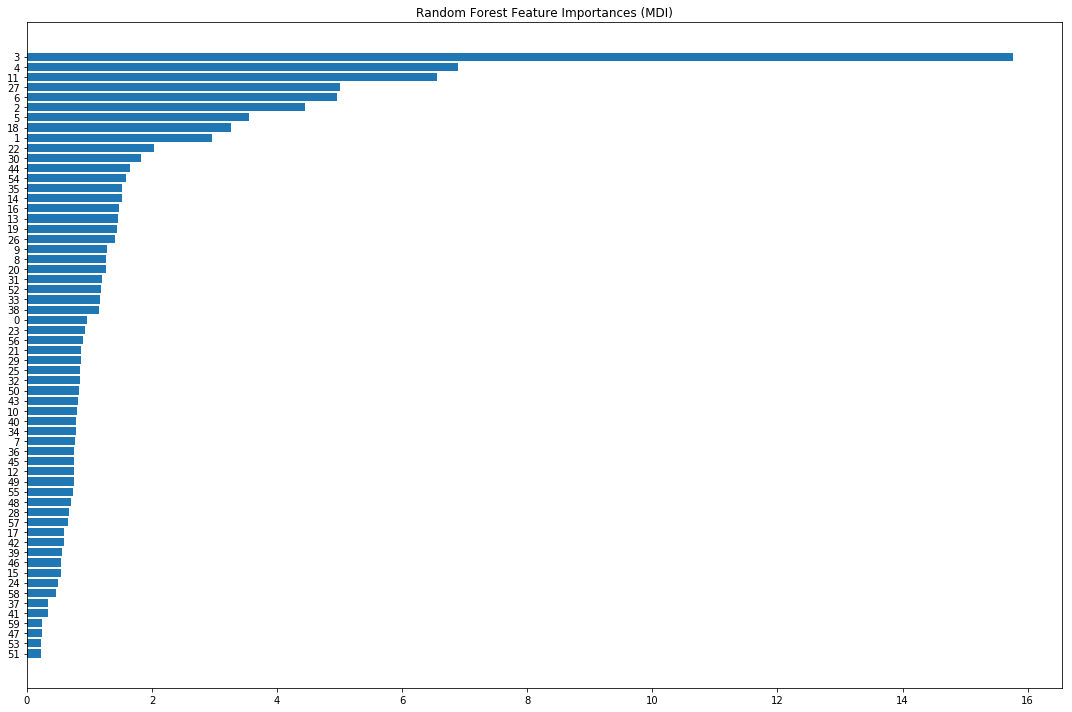

In [43]:
tree_feature_importances = (cat.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [44]:
# feature_importances = pd.DataFrame(rf.feature_importances_,
#                                    index = data_pca.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)

In [45]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA, random_state=100).fit(train_features)
X_pc = model.transform(train_features)

#features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [46]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    component_max_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
    component_mean_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
    for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value =abs( model_pca.components_[component, feature])
            component_max = component_max_list[component]
            component_mean = component_mean_list[component]
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [47]:
d = features_imp_pca((train_features), model, X_pc, features_good, features_bad, features_normal)

100%|██████████| 4672/4672 [00:00<00:00, 7516.98it/s]


In [48]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(5)]

In [49]:
sorted_d[:10]

[('feature_1128', 221),
 ('feature_1132', 185),
 ('feature_907', 143),
 ('feature_1192', 85),
 ('feature_1196', 84),
 ('feature_1000', 74),
 ('feature_779', 72),
 ('feature_1253', 71),
 ('feature_654', 66),
 ('feature_846', 63)]

In [50]:
sorted_d[-15:]

[('feature_4650', -10),
 ('feature_4661', -10),
 ('feature_4664', -10),
 ('feature_4667', -10),
 ('feature_4668', -10),
 ('feature_4669', -10),
 ('feature_4670', -10),
 ('feature_44', -12),
 ('feature_51', -12),
 ('feature_37', -14),
 ('feature_14', -16),
 ('feature_15', -18),
 ('feature_10', -20),
 ('feature_13', -22),
 ('feature_40', -24)]

In [51]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [52]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in tqdm(range(train_features.shape[0])):
    sample = pd.DataFrame(np.zeros((CHANALS, FIRST_N_FFT)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = CHANALS

        
    for s in range(FIRST_N_FFT): ##!!!
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += CHANALS

        if index_end > size[0]*FIRST_N_FFT:
            break

    old_table.append(sample.values)
  

100%|██████████| 370/370 [00:16<00:00, 21.96it/s]


In [53]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            
            

370it [00:01, 201.11it/s]


In [54]:
FE_items

[(0, 11, 14),
 (0, 40, 17),
 (0, 44, 17),
 (0, 40, 18),
 (0, 44, 18),
 (1, 11, 14),
 (1, 40, 17),
 (1, 44, 17),
 (1, 40, 18),
 (1, 44, 18),
 (2, 11, 14),
 (2, 40, 17),
 (2, 44, 17),
 (2, 40, 18),
 (2, 44, 18),
 (3, 11, 14),
 (3, 40, 17),
 (3, 44, 17),
 (3, 40, 18),
 (3, 44, 18),
 (4, 11, 14),
 (4, 40, 17),
 (4, 44, 17),
 (4, 40, 18),
 (4, 44, 18),
 (5, 11, 14),
 (5, 40, 17),
 (5, 44, 17),
 (5, 40, 18),
 (5, 44, 18),
 (6, 11, 14),
 (6, 40, 17),
 (6, 44, 17),
 (6, 40, 18),
 (6, 44, 18),
 (7, 11, 14),
 (7, 40, 17),
 (7, 44, 17),
 (7, 40, 18),
 (7, 44, 18),
 (8, 11, 14),
 (8, 40, 17),
 (8, 44, 17),
 (8, 40, 18),
 (8, 44, 18),
 (9, 11, 14),
 (9, 40, 17),
 (9, 44, 17),
 (9, 40, 18),
 (9, 44, 18),
 (10, 11, 14),
 (10, 40, 17),
 (10, 44, 17),
 (10, 40, 18),
 (10, 44, 18),
 (11, 11, 14),
 (11, 40, 17),
 (11, 44, 17),
 (11, 40, 18),
 (11, 44, 18),
 (12, 11, 14),
 (12, 40, 17),
 (12, 44, 17),
 (12, 40, 18),
 (12, 44, 18),
 (13, 11, 14),
 (13, 40, 17),
 (13, 44, 17),
 (13, 40, 18),
 (13, 44, 18),


In [55]:
best_feat = list(map(lambda x: x[0], 
    sorted(collections.Counter(list(map(lambda x: x[1], FE_items))).items(), 
           key=operator.itemgetter(1), reverse=True)))

____

In [56]:
ch = []
for i in best_feat:
    ch.append(np.argmax(np.abs(FastICA.mixing_[:, i])))

print(ch)

[8, 12, 62]


In [57]:
raw_fnames = ['data/S001R06.edf',
              'data/S001R10.edf',
              'data/S001R14.edf']

raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [58]:
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [59]:
ch_name_dict = {}

for i in range(0, 64):
    ch_name_dict[i] = raw.ch_names[i]

In [60]:
for i in ch:
    print(ch_name_dict[i])

C3
C4
O2


In [61]:
FC4
C3
O2

NameError: name 'FC4' is not defined